# PDP Plots Comparison

This notebook compares the new `pdp_sk` and `pdp_sm` functions with the existing `pred_plot_sk` and `pred_plot_sm` functions across different model types.

Key differences:
- `pred_plot_*` (fast mode): Sets other variables to mean/mode, varies one variable
- `pdp_*` with `mode="pdp"`: True partial dependence - samples from data distribution and averages predictions

## Models covered:
1. Random Forest (classification & regression)
2. XGBoost (classification & regression)
3. MLP Neural Network (classification & regression)
4. Logistic Regression (pyrsm.logistic)
5. Linear Regression (pyrsm.regress)

In [1]:
import time
import polars as pl
import pyrsm as rsm
from pyrsm.model.rforest import rforest
from pyrsm.model.xgboost import xgboost
from pyrsm.model.mlp import mlp
from pyrsm.model.logistic import logistic
from pyrsm.model.regress import regress
from pyrsm.model.visualize import pdp_sk, pdp_sm, pred_plot_sk, pred_plot_sm

In [2]:
## setup pyrsm for autoreload
%reload_ext autoreload
%autoreload 2
%aimport pyrsm

## Load Data

In [3]:
# Classification data
titanic = pl.read_parquet("https://github.com/radiant-ai-hub/raw/refs/heads/main/examples/data/model/titanic.parquet")
rsm.md("https://raw.githubusercontent.com/radiant-ai-hub/refs/heads/main/examples/data/model/titanic_description.md")
titanic = titanic.drop_nulls(subset=["age"])
print(f"Titanic: {titanic.shape}")
titanic.head()

Titanic: (1043, 10)


shape: (5, 10)
┌────────┬──────────┬────────┬────────┬───┬────────────┬───────────────────┬─────────┬─────────────┐
│ pclass ┆ survived ┆ sex    ┆ age    ┆ … ┆ fare       ┆ name              ┆ cabin   ┆ embarked    │
│ ---    ┆ ---      ┆ ---    ┆ ---    ┆   ┆ ---        ┆ ---               ┆ ---     ┆ ---         │
│ cat    ┆ cat      ┆ cat    ┆ f64    ┆   ┆ f64        ┆ str               ┆ str     ┆ cat         │
╞════════╪══════════╪════════╪════════╪═══╪════════════╪═══════════════════╪═════════╪═════════════╡
│ 1st    ┆ Yes      ┆ female ┆ 29.0   ┆ … ┆ 211.337494 ┆ Allen, Miss.      ┆ B5      ┆ Southampton │
│        ┆          ┆        ┆        ┆   ┆            ┆ Elisabeth Walton  ┆         ┆             │
│ 1st    ┆ Yes      ┆ male   ┆ 0.9167 ┆ … ┆ 151.550003 ┆ Allison, Master.  ┆ C22 C26 ┆ Southampton │
│        ┆          ┆        ┆        ┆   ┆            ┆ Hudson Trevor     ┆         ┆             │
│ 1st    ┆ No       ┆ female ┆ 2.0    ┆ … ┆ 151.550003 ┆ Allison, Miss.    ┆ C22 C26 ┆ Southampton │
│        ┆          ┆        ┆        ┆   ┆            ┆ Helen Loraine     ┆         ┆             │
│ 1st    ┆ No       ┆ male   ┆ 30.0   ┆ … ┆ 151.550003 ┆ Allison, Mr.      ┆ C22 C26 ┆ Southampton │
│        ┆          ┆        ┆        ┆   ┆            ┆ Hudson Joshua     ┆         ┆             │
│        ┆          ┆        ┆        ┆   ┆            ┆ Cre…              ┆         ┆             │
│ 1st    ┆ No       ┆ female ┆ 25.0   ┆ … ┆ 151.550003 ┆ Allison, Mrs.     ┆ C22 C26 ┆ Southampton │
│        ┆          ┆        ┆        ┆   ┆            ┆ Hudson J C (Bess… ┆         ┆             │
└────────┴──────────┴────────┴────────┴───┴────────────┴───────────────────┴─────────┴─────────────┘

In [4]:
# Regression data
salary = pl.read_parquet("https://github.com/radiant-ai-hub/raw/refs/heads/main/examples/data/basics/salary.parquet")
rsm.md("https://raw.githubusercontent.com/radiant-ai-hub/refs/heads/main/examples/data/basics/salary_description.md")
print(f"Salary: {salary.shape}")
salary.head()

Salary: (397, 6)


shape: (5, 6)
┌────────┬──────────┬────────────┬───────────────┬─────────────┬──────┐
│ salary ┆ rank     ┆ discipline ┆ yrs_since_phd ┆ yrs_service ┆ sex  │
│ ---    ┆ ---      ┆ ---        ┆ ---           ┆ ---         ┆ ---  │
│ i32    ┆ cat      ┆ cat        ┆ i32           ┆ i32         ┆ cat  │
╞════════╪══════════╪════════════╪═══════════════╪═════════════╪══════╡
│ 139750 ┆ Prof     ┆ B          ┆ 19            ┆ 18          ┆ Male │
│ 173200 ┆ Prof     ┆ B          ┆ 20            ┆ 16          ┆ Male │
│ 79750  ┆ AsstProf ┆ B          ┆ 4             ┆ 3           ┆ Male │
│ 115000 ┆ Prof     ┆ B          ┆ 45            ┆ 39          ┆ Male │
│ 141500 ┆ Prof     ┆ B          ┆ 40            ┆ 41          ┆ Male │
└────────┴──────────┴────────────┴───────────────┴─────────────┴──────┘

In [5]:
# Common variables
clf_evars = ["age", "sex", "pclass", "sibsp"]
reg_evars = ["yrs_since_phd", "yrs_service", "rank", "discipline"]

---
# 1. Random Forest

## 1a. Random Forest Classification

In [6]:
rf_clf = rforest(
    data=titanic.to_pandas(),
    rvar="survived", lev="Yes", evar=clf_evars,
    mod_type="classification", n_estimators=100, random_state=1234,
)
rf_clf.summary()

Random Forest
Data                 : Not provided
Response variable    : survived
Level                : Yes
Explanatory variables: age, sex, pclass, sibsp
OOB                  : True
Model type           : classification
Nr. of features      : (4, 6)
Nr. of observations  : 1,043
max_features         : sqrt (2)
n_estimators         : 100
min_samples_leaf     : 1
max_samples          : 1.0
random_state         : 1234
AUC                  : 0.813

Estimation data      :
shape: (5, 6)
┌────────┬───────┬────────────┬──────────┬────────────┬────────────┐
│ age    ┆ sibsp ┆ sex_female ┆ sex_male ┆ pclass_2nd ┆ pclass_3rd │
│ ---    ┆ ---   ┆ ---        ┆ ---      ┆ ---        ┆ ---        │
│ f64    ┆ i32   ┆ u8         ┆ u8       ┆ u8         ┆ u8         │
╞════════╪═══════╪════════════╪══════════╪════════════╪════════════╡
│ 29.0   ┆ 0     ┆ 1          ┆ 0        ┆ 0          ┆ 0          │
│ 0.9167 ┆ 1     ┆ 0          ┆ 1        ┆ 0          ┆ 0          │
│ 2.0    ┆ 1     ┆ 1          

pred_plot_sk: 0.083s


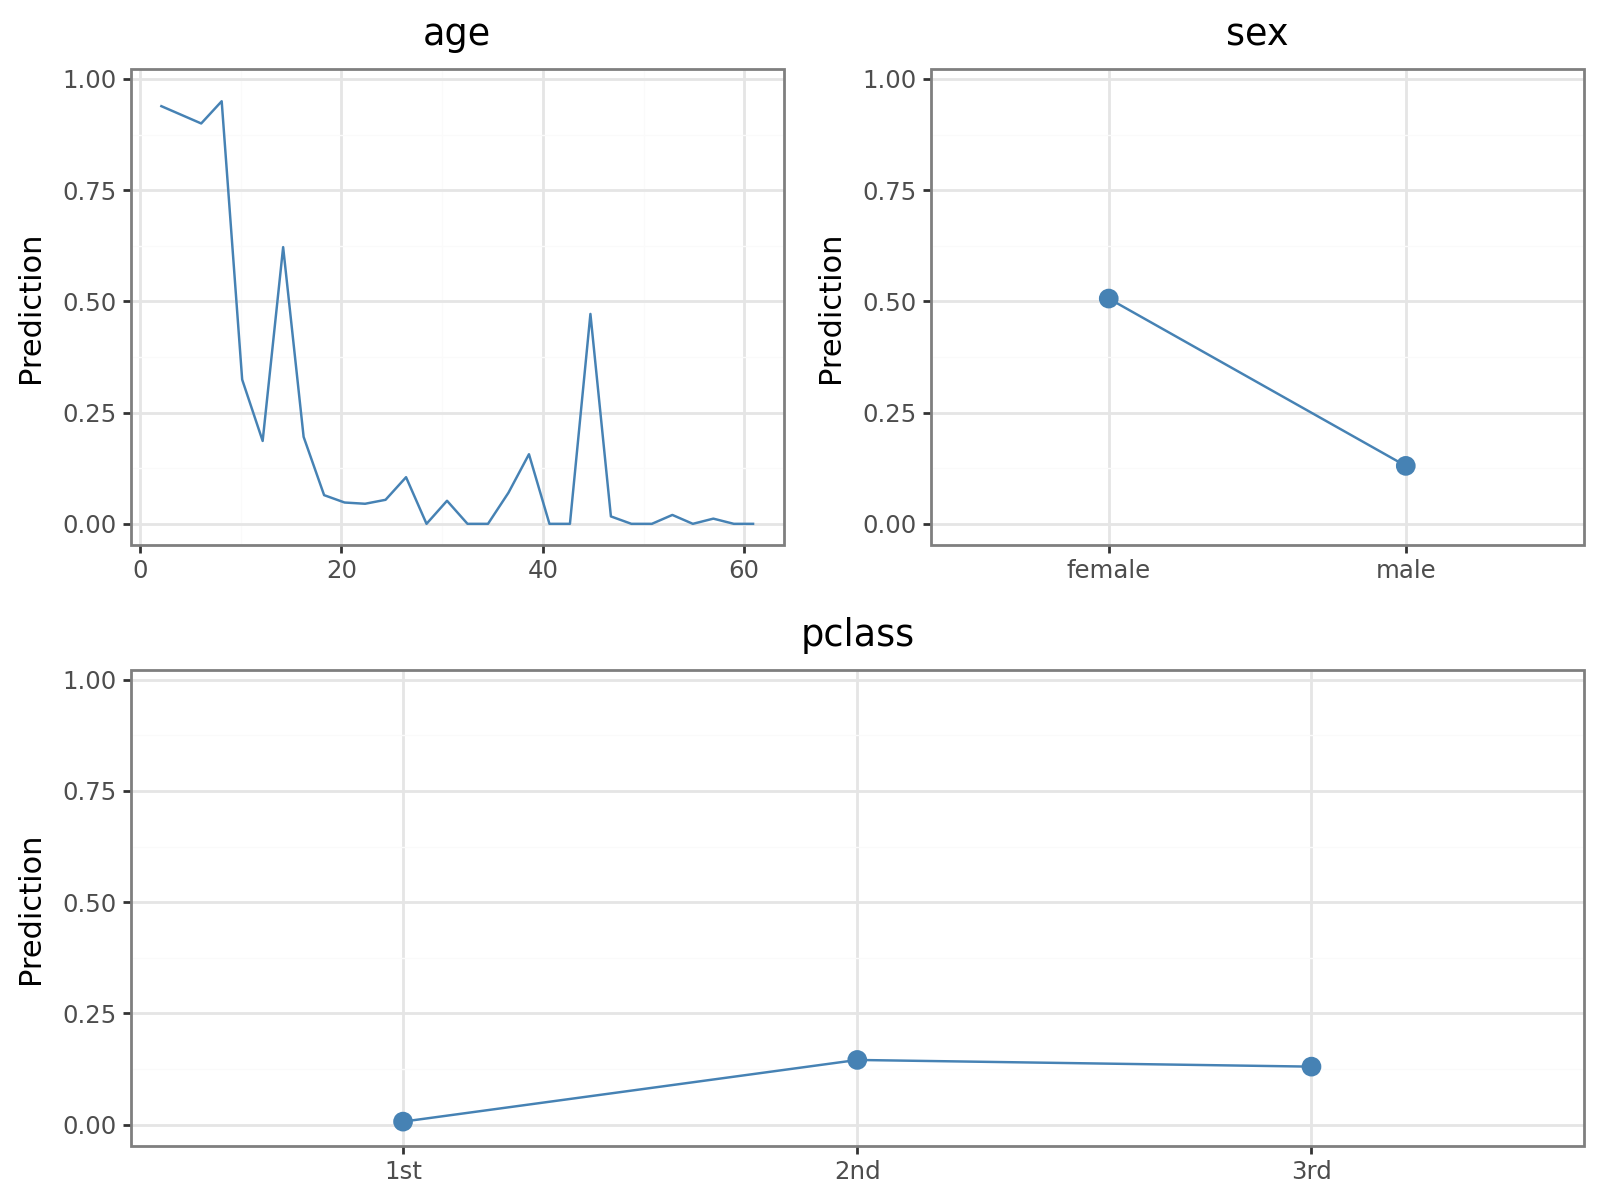

In [7]:
# pred_plot_sk (existing)
start = time.time()
plot_pred = pred_plot_sk(rf_clf.fitted, titanic, incl=["age", "sex", "pclass"], nnv=30)
rf_clf_pred_time = time.time() - start
print(f"pred_plot_sk: {rf_clf_pred_time:.3f}s")
plot_pred

pdp_sk (fast): 0.095s


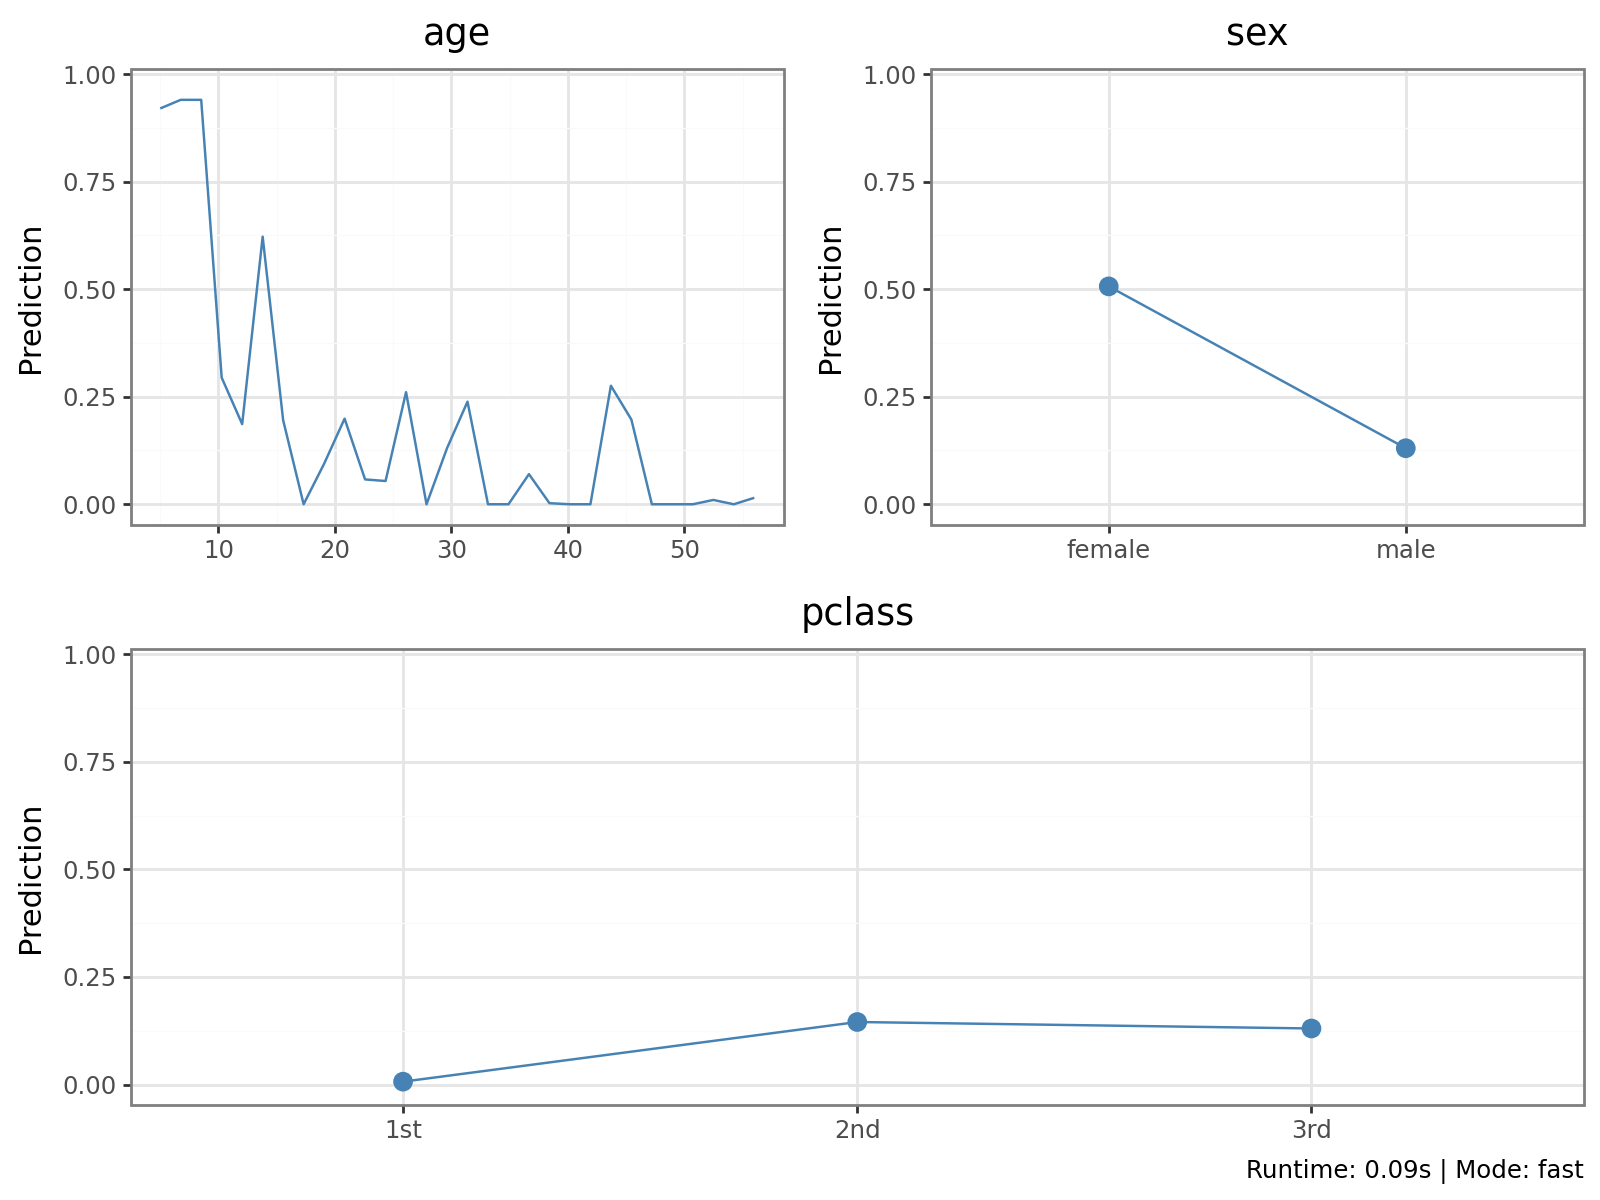

In [8]:
# pdp_sk - Fast Mode
plot_fast, data_fast, rf_clf_fast_time = pdp_sk(
    rf_clf.fitted, titanic, incl=["age", "sex", "pclass"], mode="fast", grid_resolution=30
)
print(f"pdp_sk (fast): {rf_clf_fast_time:.3f}s")
plot_fast

pdp_sk (pdp): 0.380s


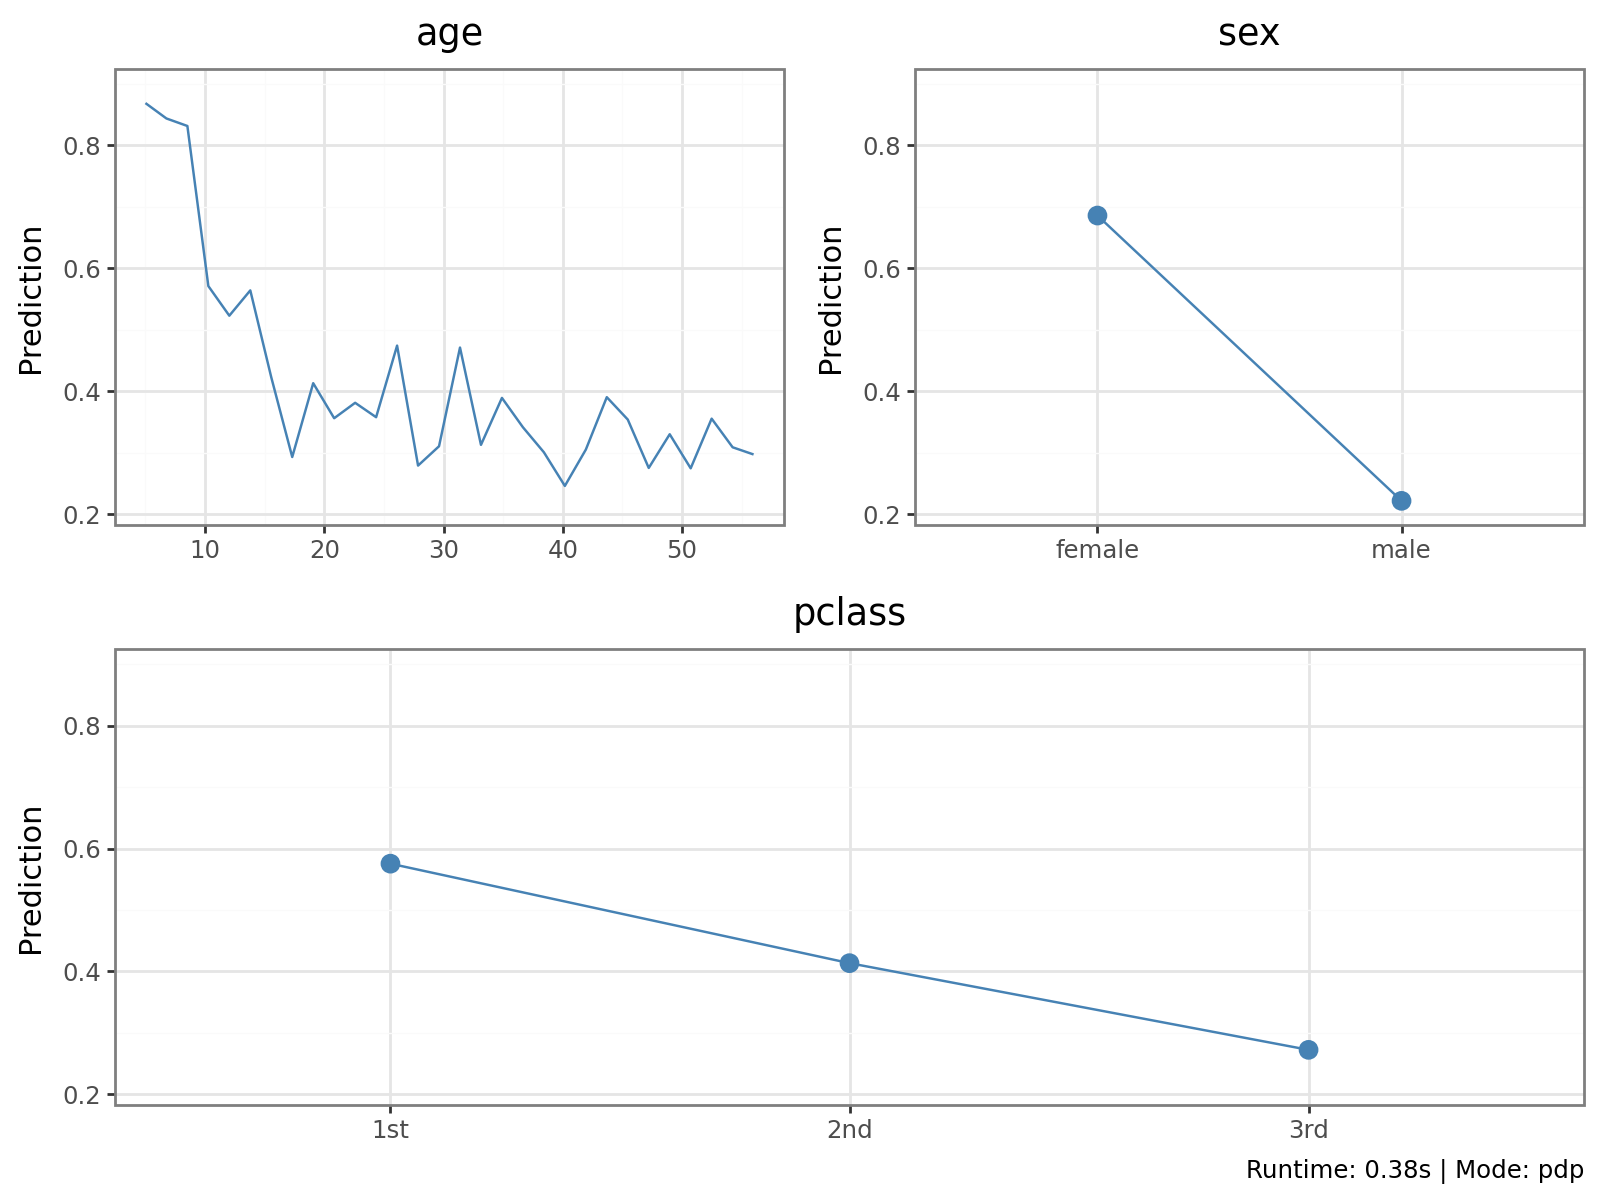

In [9]:
# pdp_sk - PDP Mode
plot_pdp, data_pdp, rf_clf_pdp_time = pdp_sk(
    rf_clf.fitted, titanic, incl=["age", "sex", "pclass"], mode="pdp", n_sample=500, grid_resolution=30
)
print(f"pdp_sk (pdp): {rf_clf_pdp_time:.3f}s")
plot_pdp

In [10]:
# Compare underlying data
print("Fast mode - age predictions:")
print(data_fast["age"].head(10))
print("\nPDP mode - age predictions:")
print(data_pdp["age"].head(10))

Fast mode - age predictions:
shape: (10, 2)
┌───────────┬────────────┐
│ age       ┆ prediction │
│ ---       ┆ ---        │
│ f64       ┆ f64        │
╞═══════════╪════════════╡
│ 5.0       ┆ 0.92       │
│ 6.758621  ┆ 0.94       │
│ 8.517241  ┆ 0.94       │
│ 10.275862 ┆ 0.294286   │
│ 12.034483 ┆ 0.186286   │
│ 13.793103 ┆ 0.622036   │
│ 15.551724 ┆ 0.195444   │
│ 17.310345 ┆ 0.0        │
│ 19.068966 ┆ 0.094138   │
│ 20.827586 ┆ 0.198971   │
└───────────┴────────────┘

PDP mode - age predictions:
shape: (10, 2)
┌───────────┬────────────┐
│ age       ┆ prediction │
│ ---       ┆ ---        │
│ f64       ┆ f64        │
╞═══════════╪════════════╡
│ 5.0       ┆ 0.868655   │
│ 6.758621  ┆ 0.843633   │
│ 8.517241  ┆ 0.831398   │
│ 10.275862 ┆ 0.571027   │
│ 12.034483 ┆ 0.522845   │
│ 13.793103 ┆ 0.564005   │
│ 15.551724 ┆ 0.422686   │
│ 17.310345 ┆ 0.293015   │
│ 19.068966 ┆ 0.413062   │
│ 20.827586 ┆ 0.356077   │
└───────────┴────────────┘


RF Classification Interactions: 1.762s


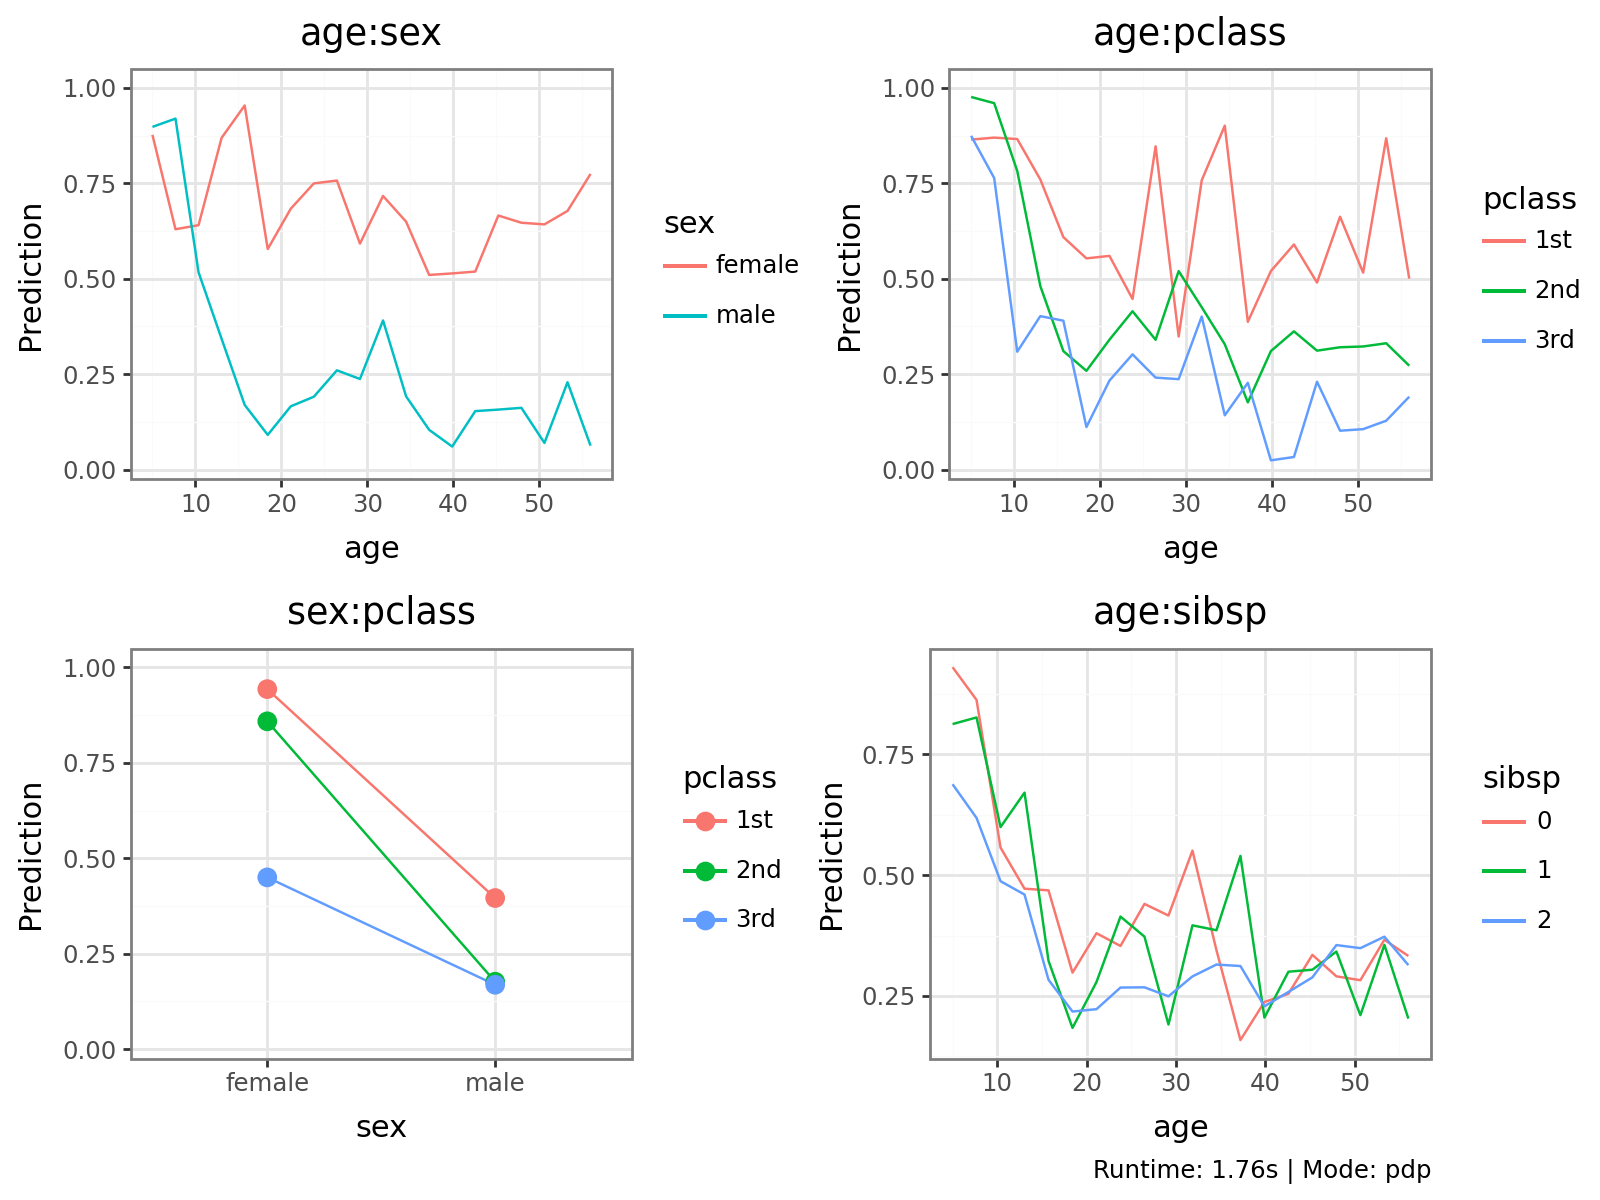

In [ ]:
# Interaction plots - all types
# num:cat (age:sex, age:pclass), cat:cat (sex:pclass), num:num (age:sibsp)
plot_int, _, rf_clf_int_time = pdp_sk(
    rf_clf.fitted, titanic, incl=[],
    incl_int=["age:sex", "age:pclass", "sex:pclass", "age:sibsp"],
    mode="pdp", n_sample=300, grid_resolution=20
)
print(f"RF Classification Interactions: {rf_clf_int_time:.3f}s")
plot_int

## 1b. Random Forest Regression

In [12]:
rf_reg_xgb = rforest(
    data=salary.to_pandas(),
    rvar="salary", evar=reg_evars,
    mod_type="regression", n_estimators=100, random_state=1234,
)
rf_reg.summary()

Random Forest
Data                 : Not provided
Response variable    : salary
Explanatory variables: yrs_since_phd, yrs_service, rank, discipline
OOB                  : True
Model type           : regression
Nr. of features      : (4, 6)
Nr. of observations  : 397
max_features         : sqrt (2)
n_estimators         : 100
min_samples_leaf     : 1
max_samples          : 1.0
random_state         : 1234
Model fit            :
    n    r2            mse        mae
  397  0.33  613466447.712  17724.573

Estimation data      :
shape: (5, 6)
┌───────────────┬─────────────┬──────────────┬──────────────┬───────────────┬───────────┐
│ yrs_since_phd ┆ yrs_service ┆ discipline_A ┆ discipline_B ┆ rank_AsstProf ┆ rank_Prof │
│ ---           ┆ ---         ┆ ---          ┆ ---          ┆ ---           ┆ ---       │
│ i32           ┆ i32         ┆ u8           ┆ u8           ┆ u8            ┆ u8        │
╞═══════════════╪═════════════╪══════════════╪══════════════╪═══════════════╪═══════════╡
│ 19   

pdp_sk regression: 0.621s


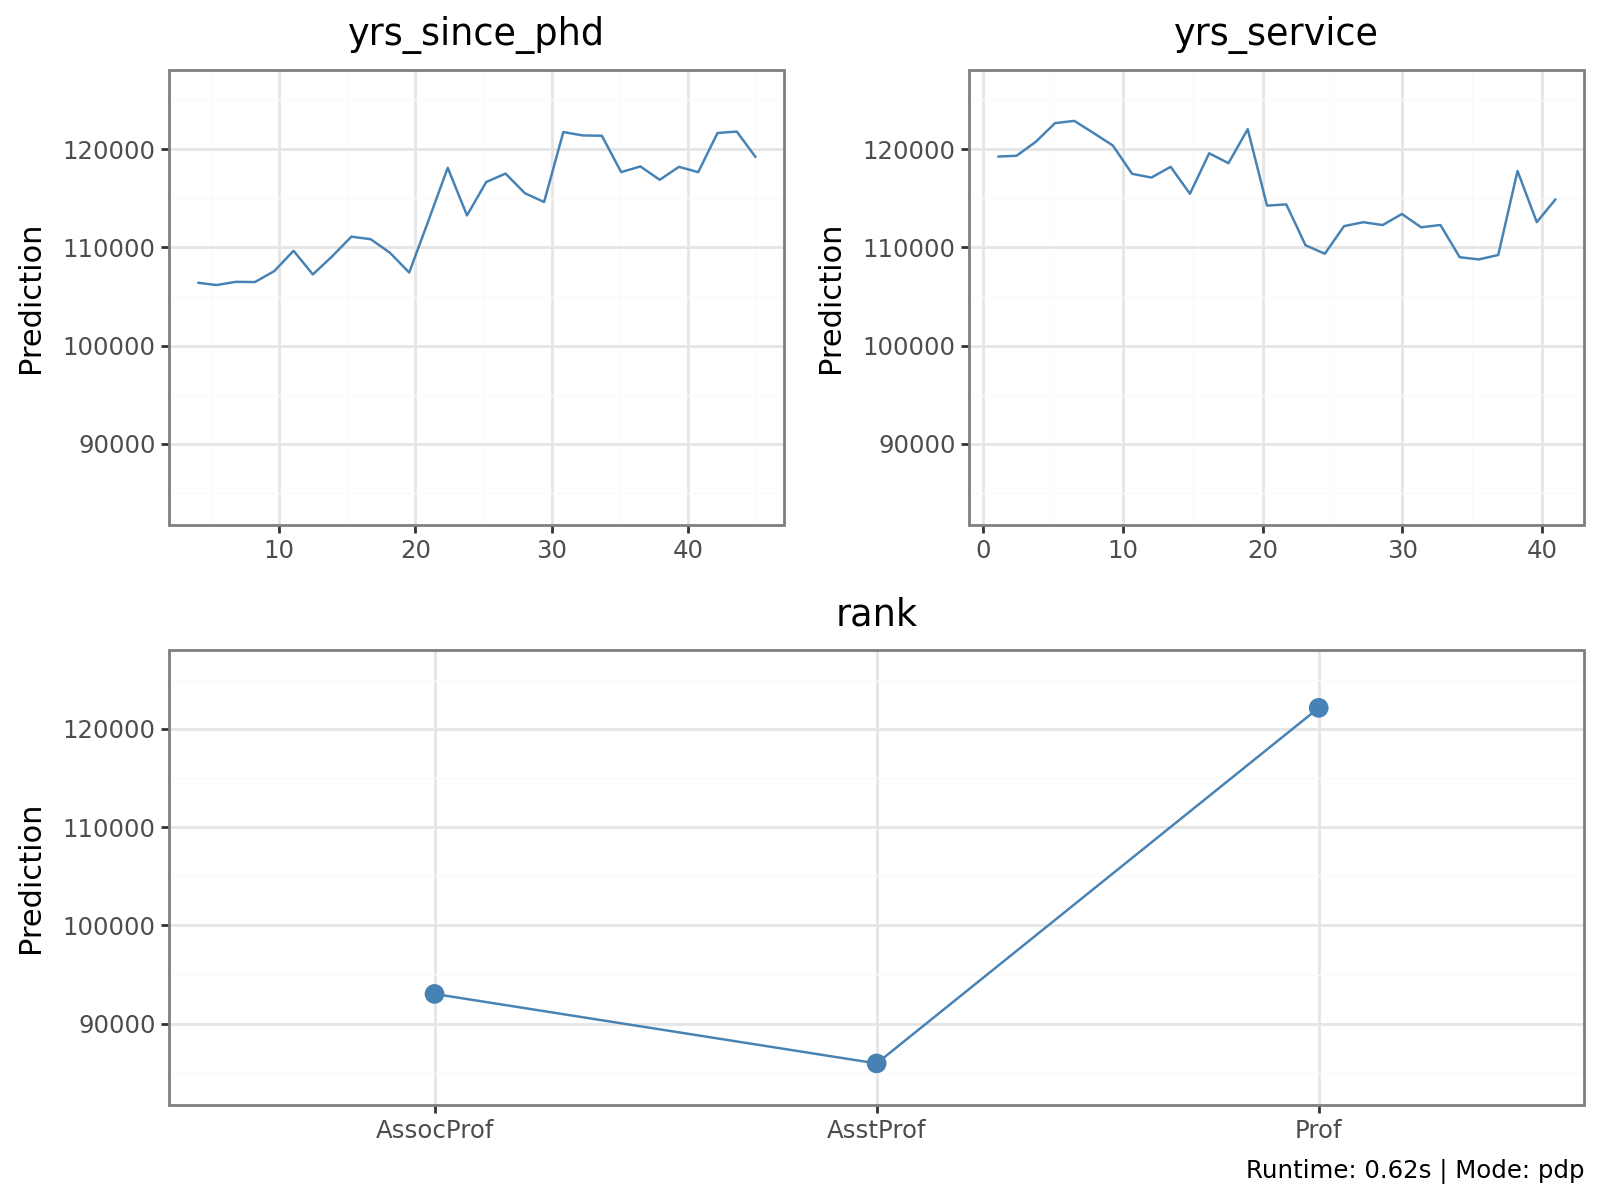

In [13]:
plot_rf_reg, _, rf_reg_pdp_time = pdp_sk(
    rf_reg.fitted, salary, incl=["yrs_since_phd", "yrs_service", "rank"],
    mode="pdp", n_sample=300, grid_resolution=30
)
print(f"pdp_sk regression: {rf_reg_pdp_time:.3f}s")
plot_rf_reg

RF Regression Interactions: 1.314s


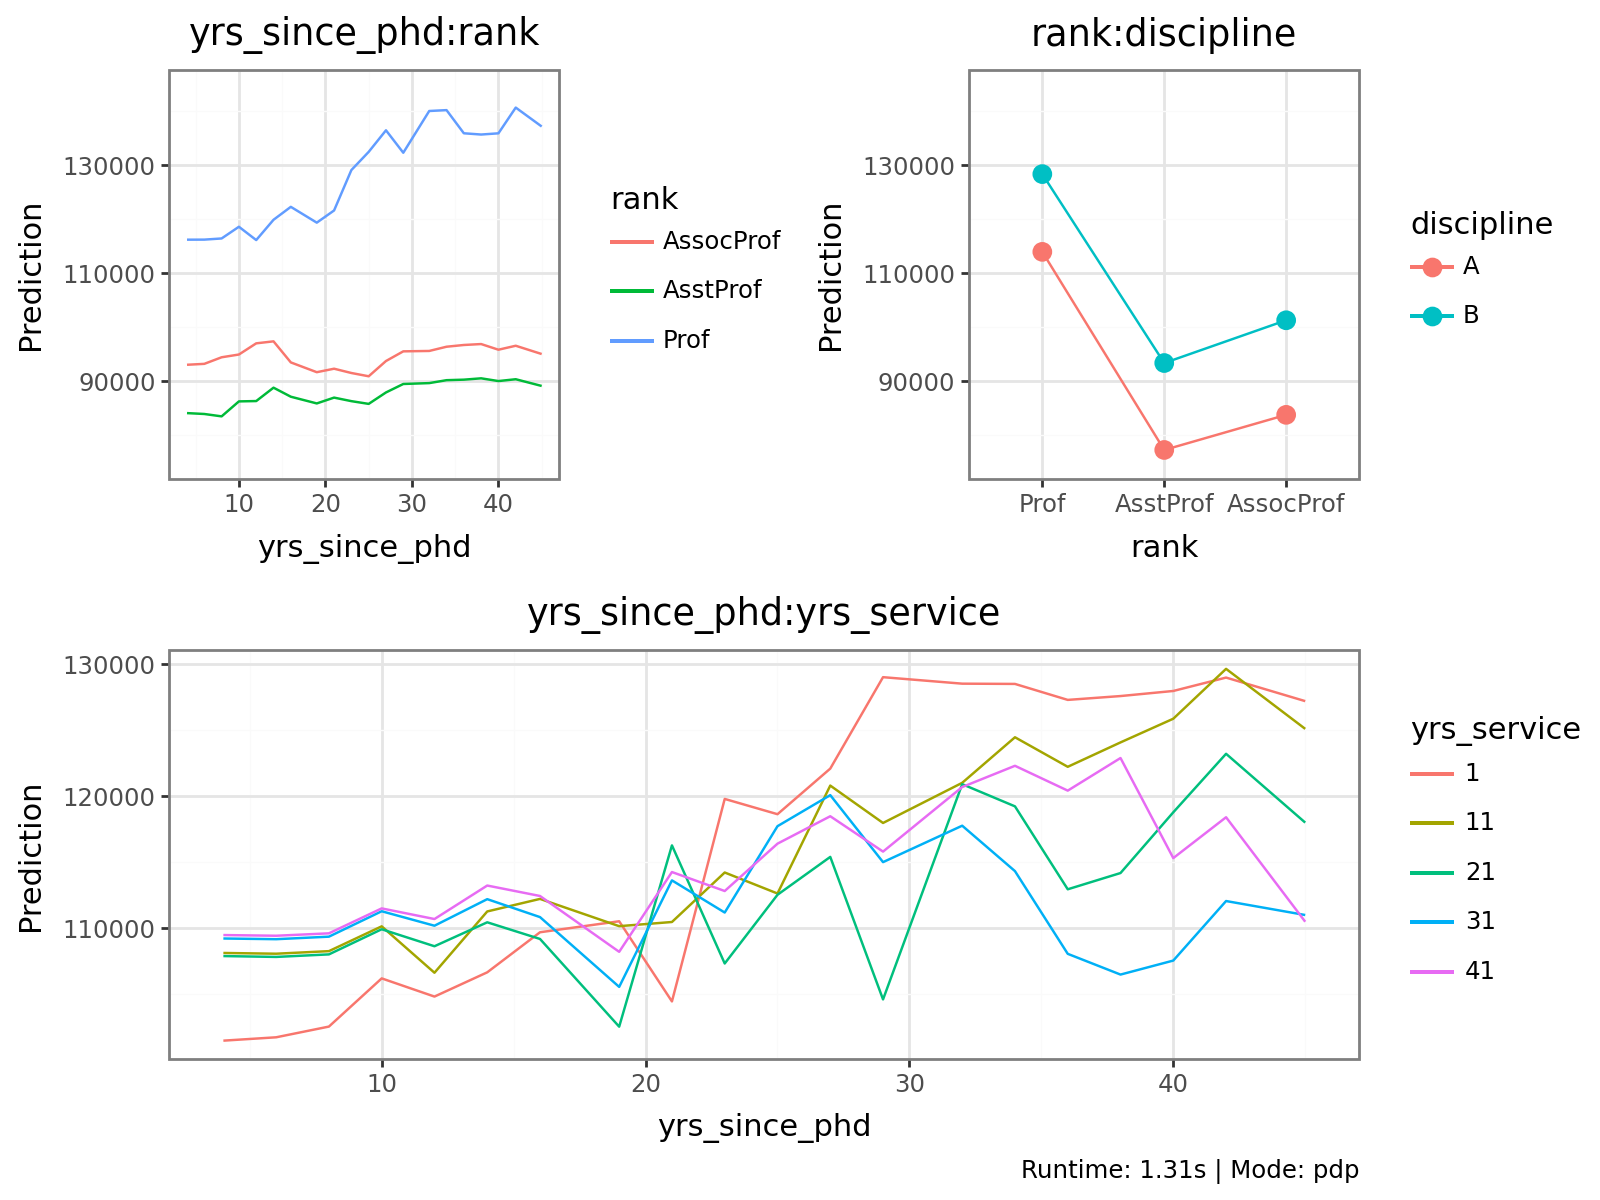

In [14]:
# RF Regression Interactions
# num:cat, cat:cat, num:num
plot_rf_reg_int, _, rf_reg_int_time = pdp_sk(
    rf_reg.fitted, salary, incl=[],
    incl_int=["yrs_since_phd:rank", "rank:discipline", "yrs_since_phd:yrs_service"],
    mode="pdp", n_sample=300, grid_resolution=20
)
print(f"RF Regression Interactions: {rf_reg_int_time:.3f}s")
plot_rf_reg_int

---
# 2. XGBoost

## 2a. XGBoost Classification

In [15]:
xgb_clf = xgboost(
    data=titanic.to_pandas(),
    rvar="survived", lev="Yes", evar=clf_evars,
    mod_type="classification", n_estimators=100, max_depth=4, random_state=1234,
)
xgb_clf.summary()

XGBoost
Data                 : Not provided
Response variable    : survived
Level                : Yes
Explanatory variables: age, sex, pclass, sibsp
Model type           : classification
Nr. of features      : (4, 6)
Nr. of observations  : 1,043
n_estimators         : 100
max_depth            : 4
min_child_weight     : 1
learning_rate        : 0.3
subsample            : 1.0
colsample_bytree     : 1.0
random_state         : 1234
AUC                  : 0.934

Estimation data      :
shape: (5, 6)
┌────────┬───────┬────────────┬──────────┬────────────┬────────────┐
│ age    ┆ sibsp ┆ sex_female ┆ sex_male ┆ pclass_2nd ┆ pclass_3rd │
│ ---    ┆ ---   ┆ ---        ┆ ---      ┆ ---        ┆ ---        │
│ f64    ┆ i32   ┆ u8         ┆ u8       ┆ u8         ┆ u8         │
╞════════╪═══════╪════════════╪══════════╪════════════╪════════════╡
│ 29.0   ┆ 0     ┆ 1          ┆ 0        ┆ 0          ┆ 0          │
│ 0.9167 ┆ 1     ┆ 0          ┆ 1        ┆ 0          ┆ 0          │
│ 2.0    ┆ 1     

pred_plot_sk: 0.109s


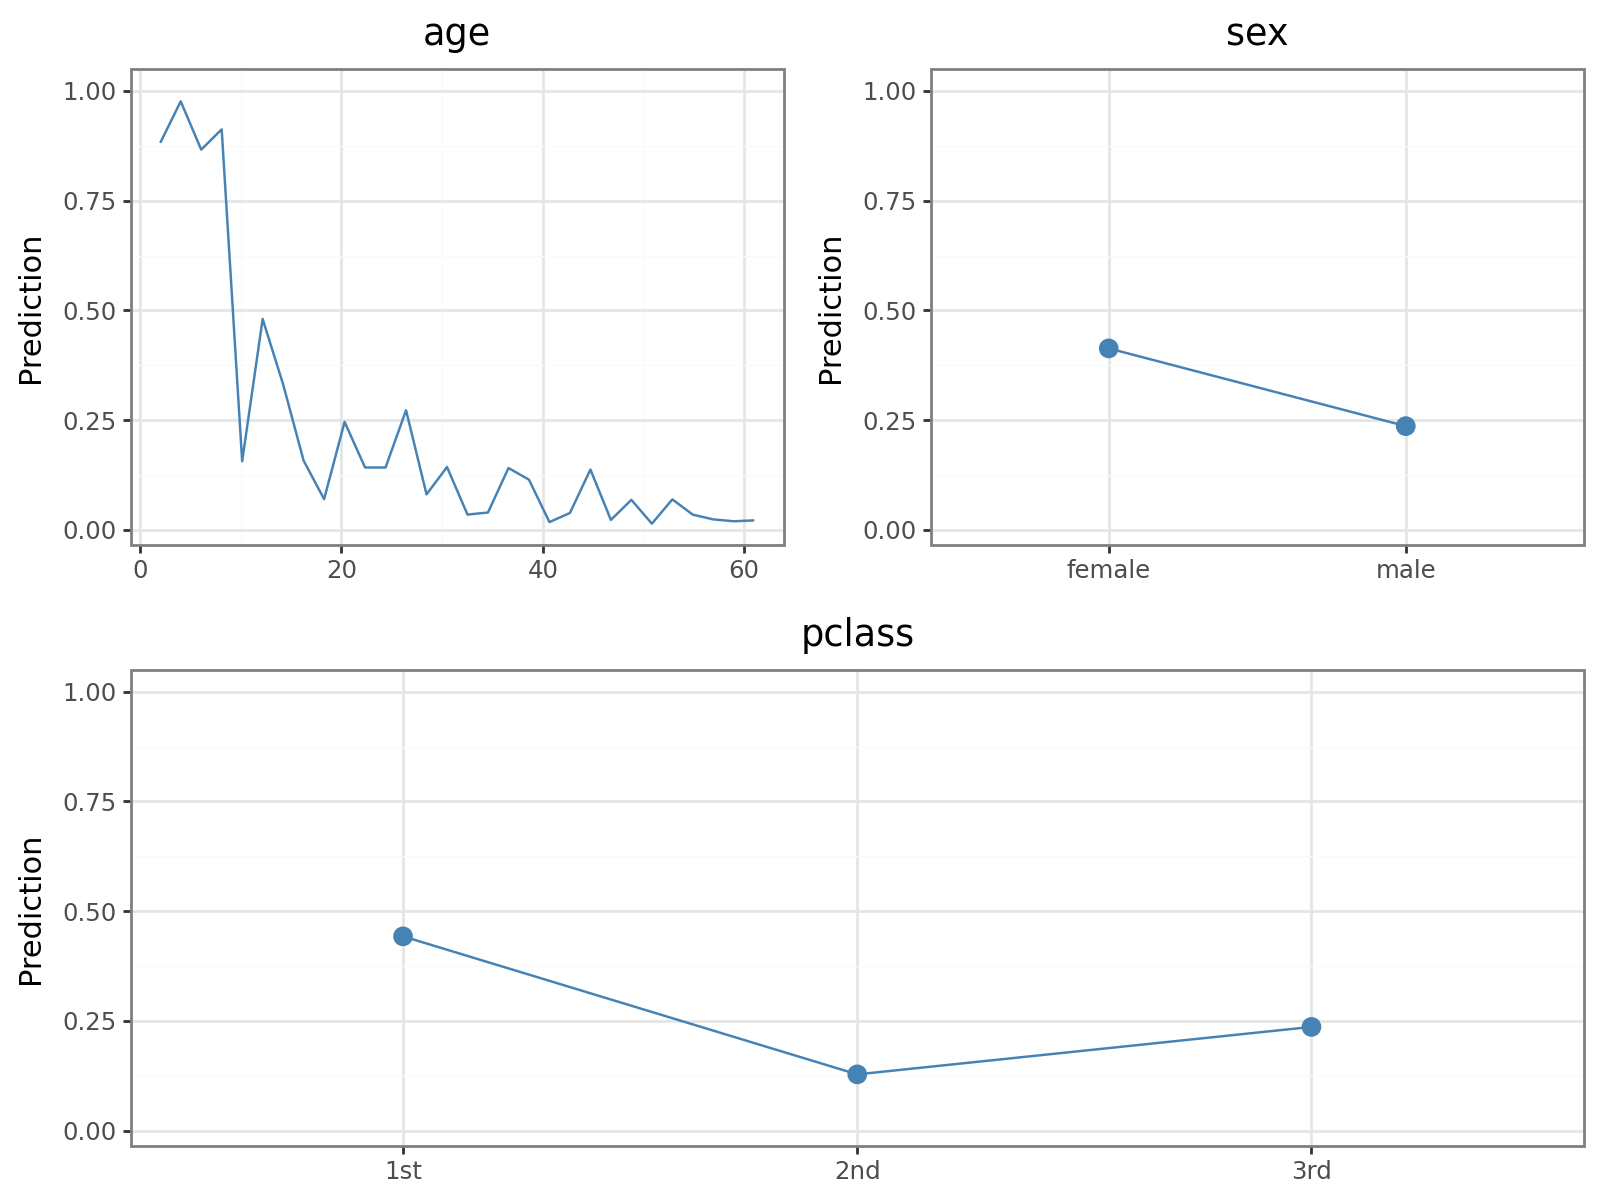

In [16]:
# pred_plot_sk
start = time.time()
plot_xgb_pred = pred_plot_sk(xgb_clf.fitted, titanic, incl=["age", "sex", "pclass"], nnv=30)
xgb_clf_pred_time = time.time() - start
print(f"pred_plot_sk: {xgb_clf_pred_time:.3f}s")
plot_xgb_pred

pdp_sk (fast): 0.073s


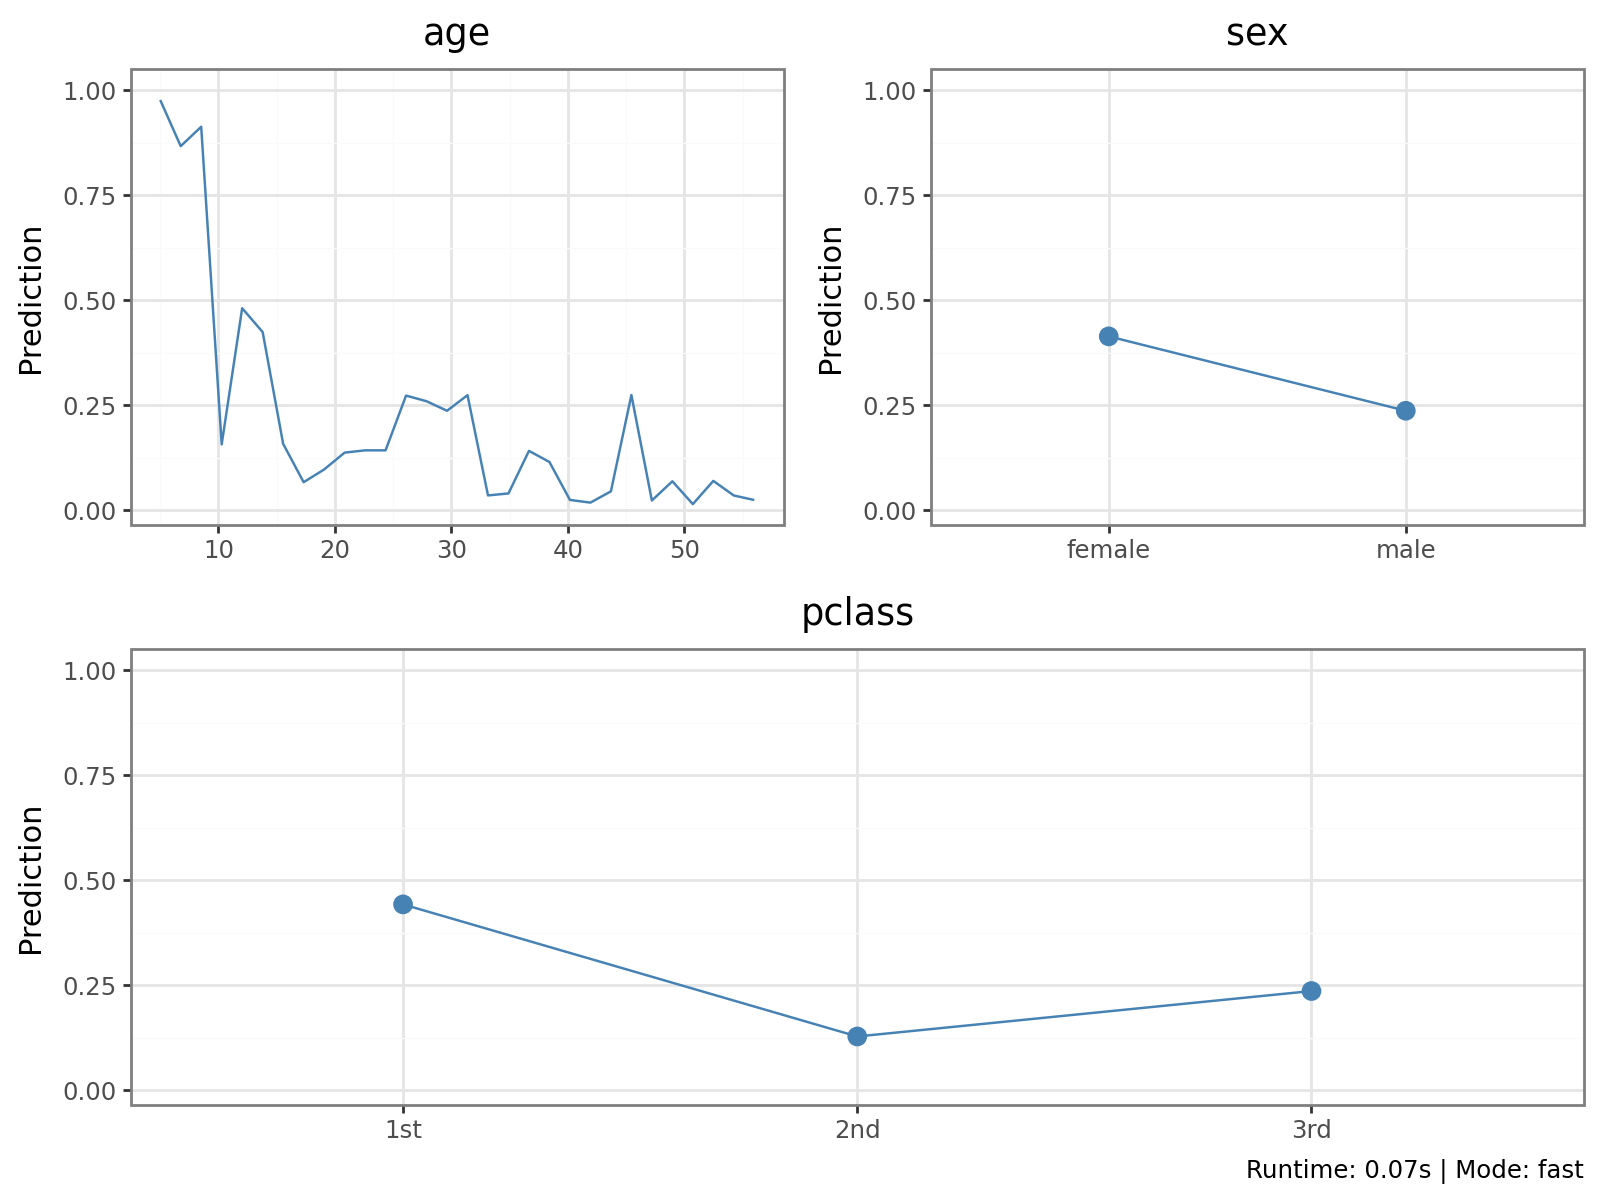

In [17]:
# pdp_sk - Fast
plot_xgb_fast, _, xgb_clf_fast_time = pdp_sk(
    xgb_clf.fitted, titanic, incl=["age", "sex", "pclass"], mode="fast", grid_resolution=30
)
print(f"pdp_sk (fast): {xgb_clf_fast_time:.3f}s")
plot_xgb_fast

pdp_sk (pdp): 0.494s


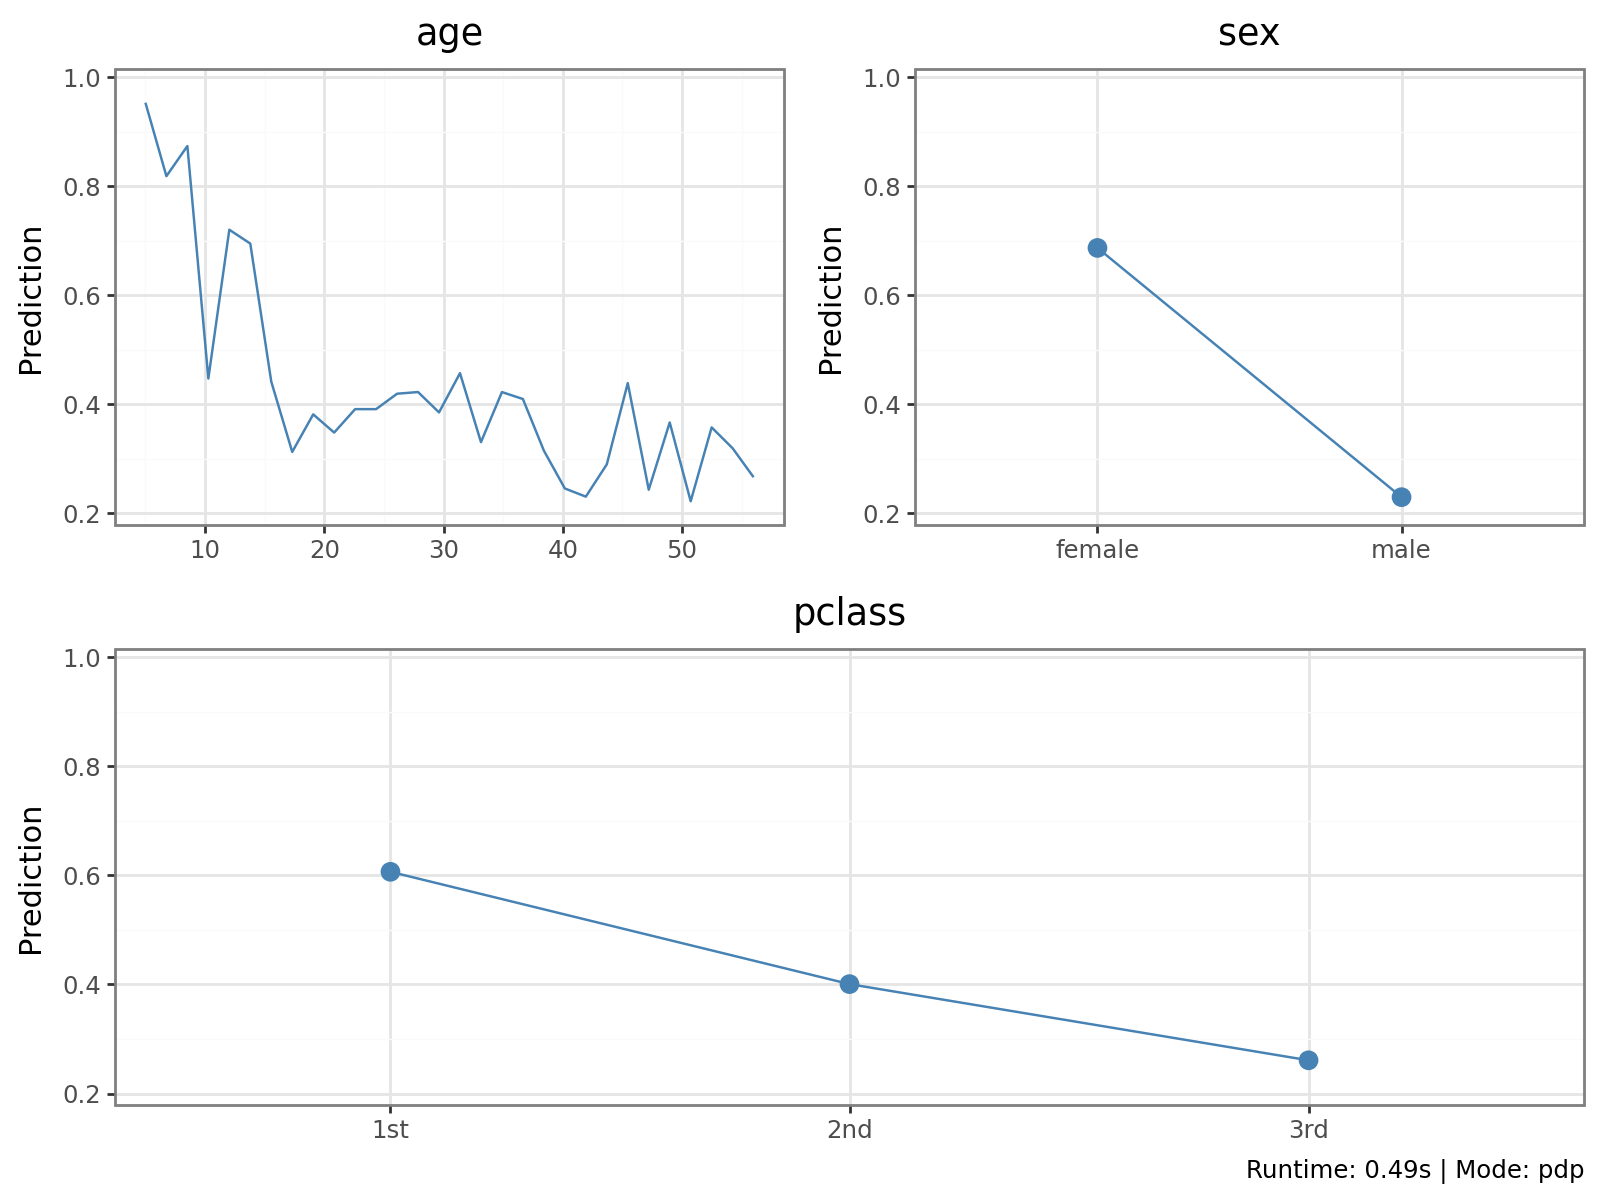

In [18]:
# pdp_sk - PDP
plot_xgb_pdp, _, xgb_clf_pdp_time = pdp_sk(
    xgb_clf.fitted, titanic, incl=["age", "sex", "pclass"], mode="pdp", n_sample=500, grid_resolution=30
)
print(f"pdp_sk (pdp): {xgb_clf_pdp_time:.3f}s")
plot_xgb_pdp

XGBoost Classification Interactions: 3.033s


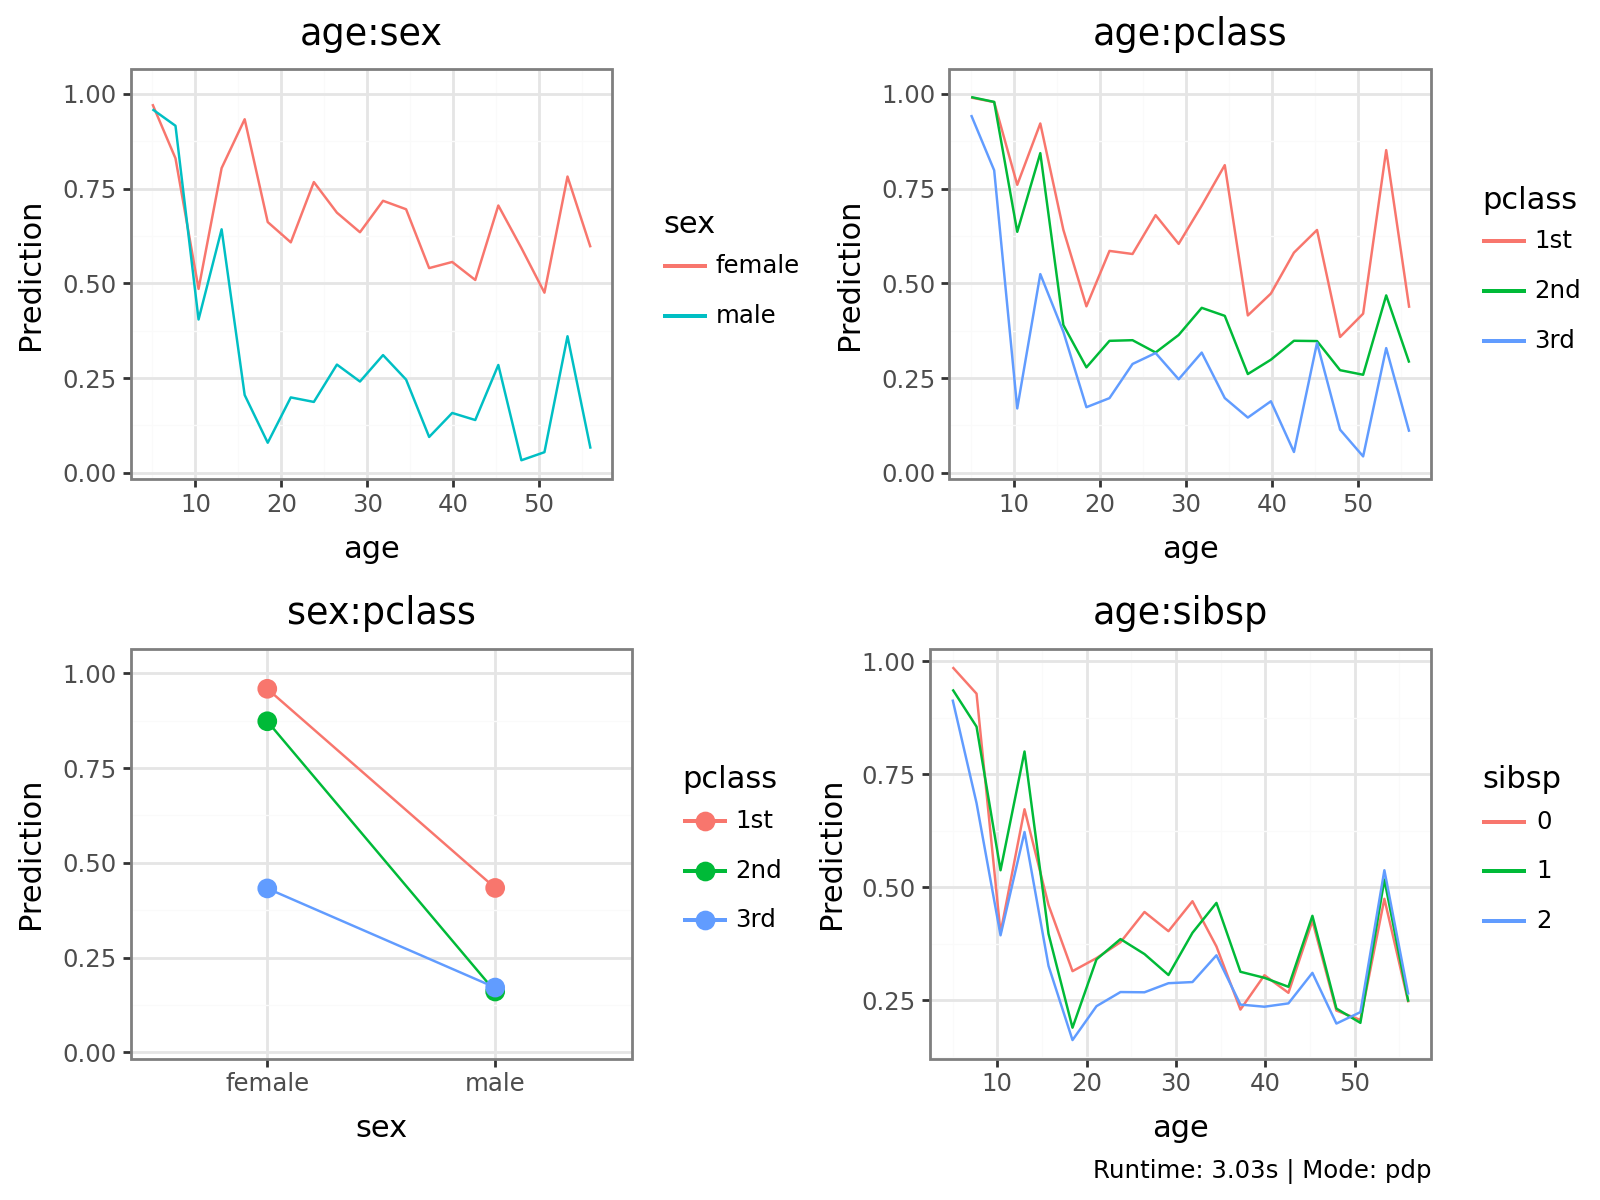

In [19]:
# XGBoost Classification Interactions
plot_xgb_clf_int, _, xgb_clf_int_time = pdp_sk(
    xgb_clf.fitted, titanic, incl=[],
    incl_int=["age:sex", "age:pclass", "sex:pclass", "age:sibsp"],
    mode="pdp", n_sample=300, grid_resolution=20
)
print(f"XGBoost Classification Interactions: {xgb_clf_int_time:.3f}s")
plot_xgb_clf_int

## 2b. XGBoost Regression

In [20]:
xgb_reg_xgb = xgboost(
    data=salary.to_pandas(),
    rvar="salary", evar=reg_evars,
    mod_type="regression", n_estimators=100, max_depth=4, random_state=1234,
)
xgb_reg.summary()

XGBoost
Data                 : Not provided
Response variable    : salary
Explanatory variables: yrs_since_phd, yrs_service, rank, discipline
Model type           : regression
Nr. of features      : (4, 6)
Nr. of observations  : 397
n_estimators         : 100
max_depth            : 4
min_child_weight     : 1
learning_rate        : 0.3
subsample            : 1.0
colsample_bytree     : 1.0
random_state         : 1234
Model fit            :
    n     r2            mse       mae
  397  0.845  141715178.394  7769.973

Estimation data      :
shape: (5, 6)
┌───────────────┬─────────────┬──────────────┬──────────────┬───────────────┬───────────┐
│ yrs_since_phd ┆ yrs_service ┆ discipline_A ┆ discipline_B ┆ rank_AsstProf ┆ rank_Prof │
│ ---           ┆ ---         ┆ ---          ┆ ---          ┆ ---           ┆ ---       │
│ i32           ┆ i32         ┆ u8           ┆ u8           ┆ u8            ┆ u8        │
╞═══════════════╪═════════════╪══════════════╪══════════════╪═══════════════╪═══════

pdp_sk regression: 0.808s


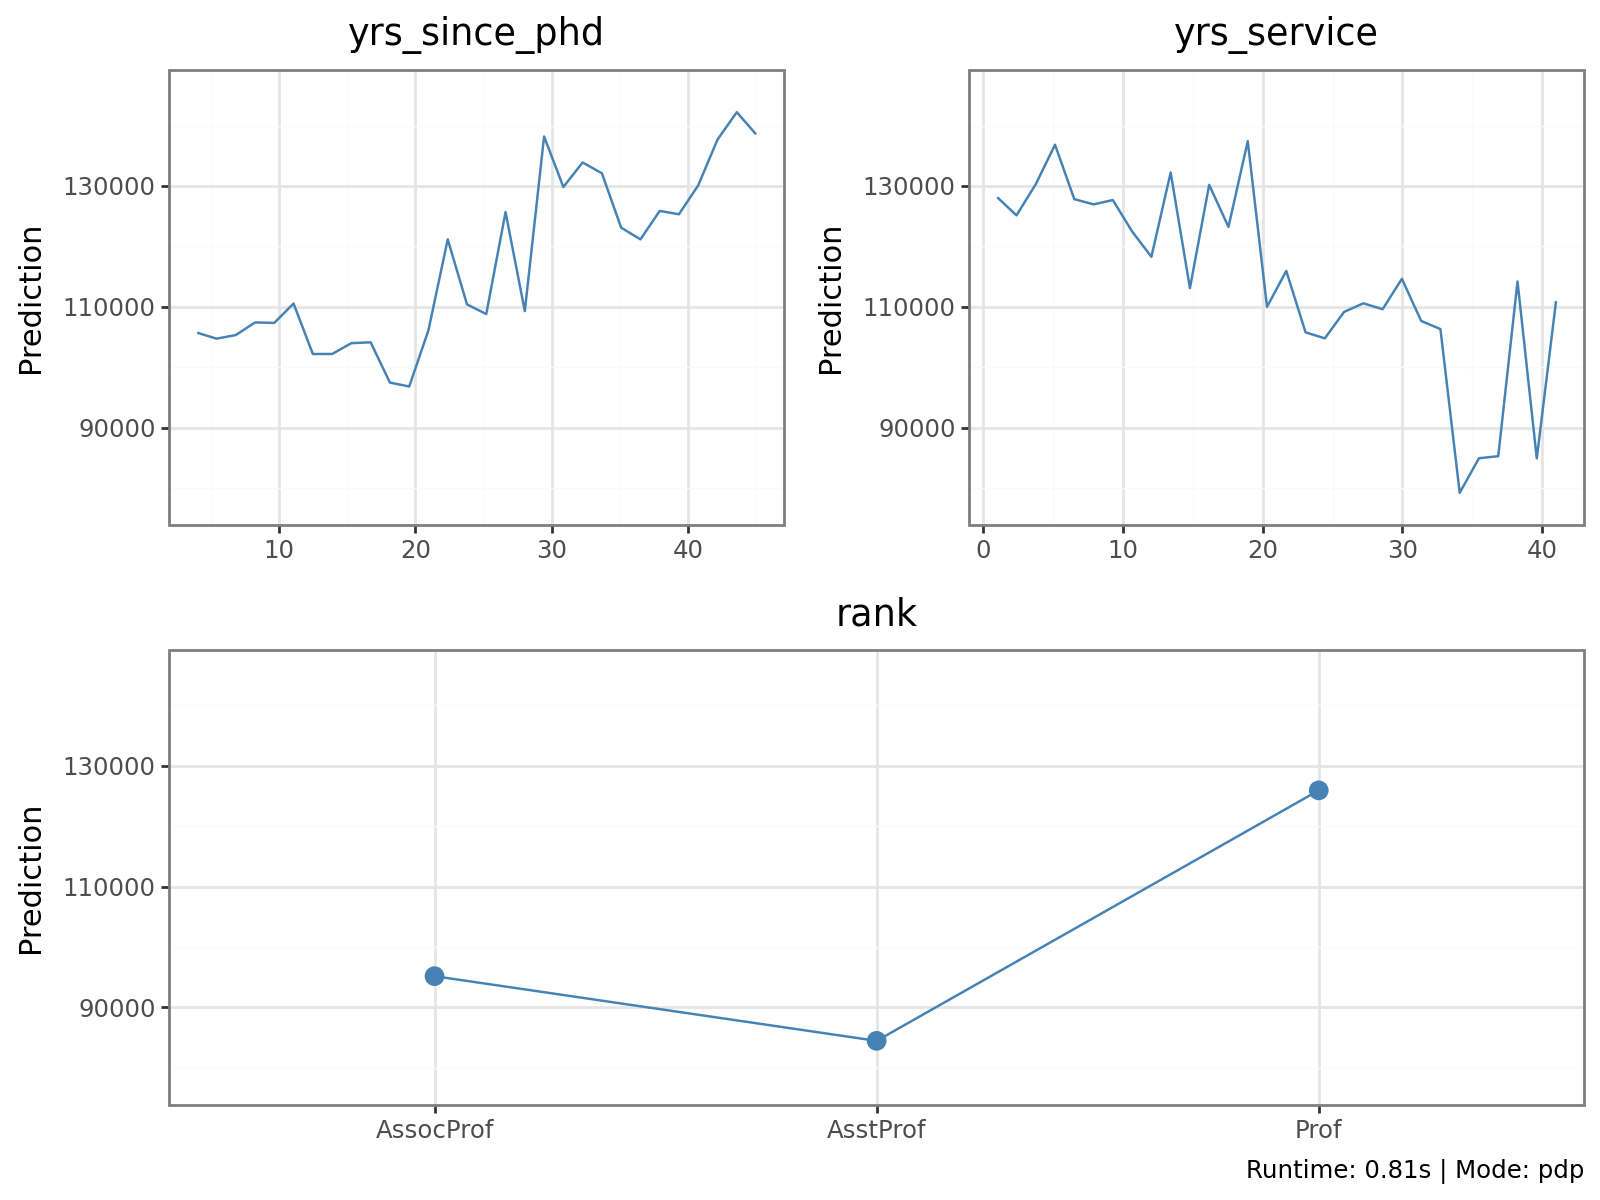

In [21]:
plot_xgb_reg, _, xgb_reg_pdp_time = pdp_sk(
    xgb_reg.fitted, salary, incl=["yrs_since_phd", "yrs_service", "rank"],
    mode="pdp", n_sample=300, grid_resolution=30
)
print(f"pdp_sk regression: {xgb_reg_pdp_time:.3f}s")
plot_xgb_reg

XGBoost Regression Interactions: 2.267s


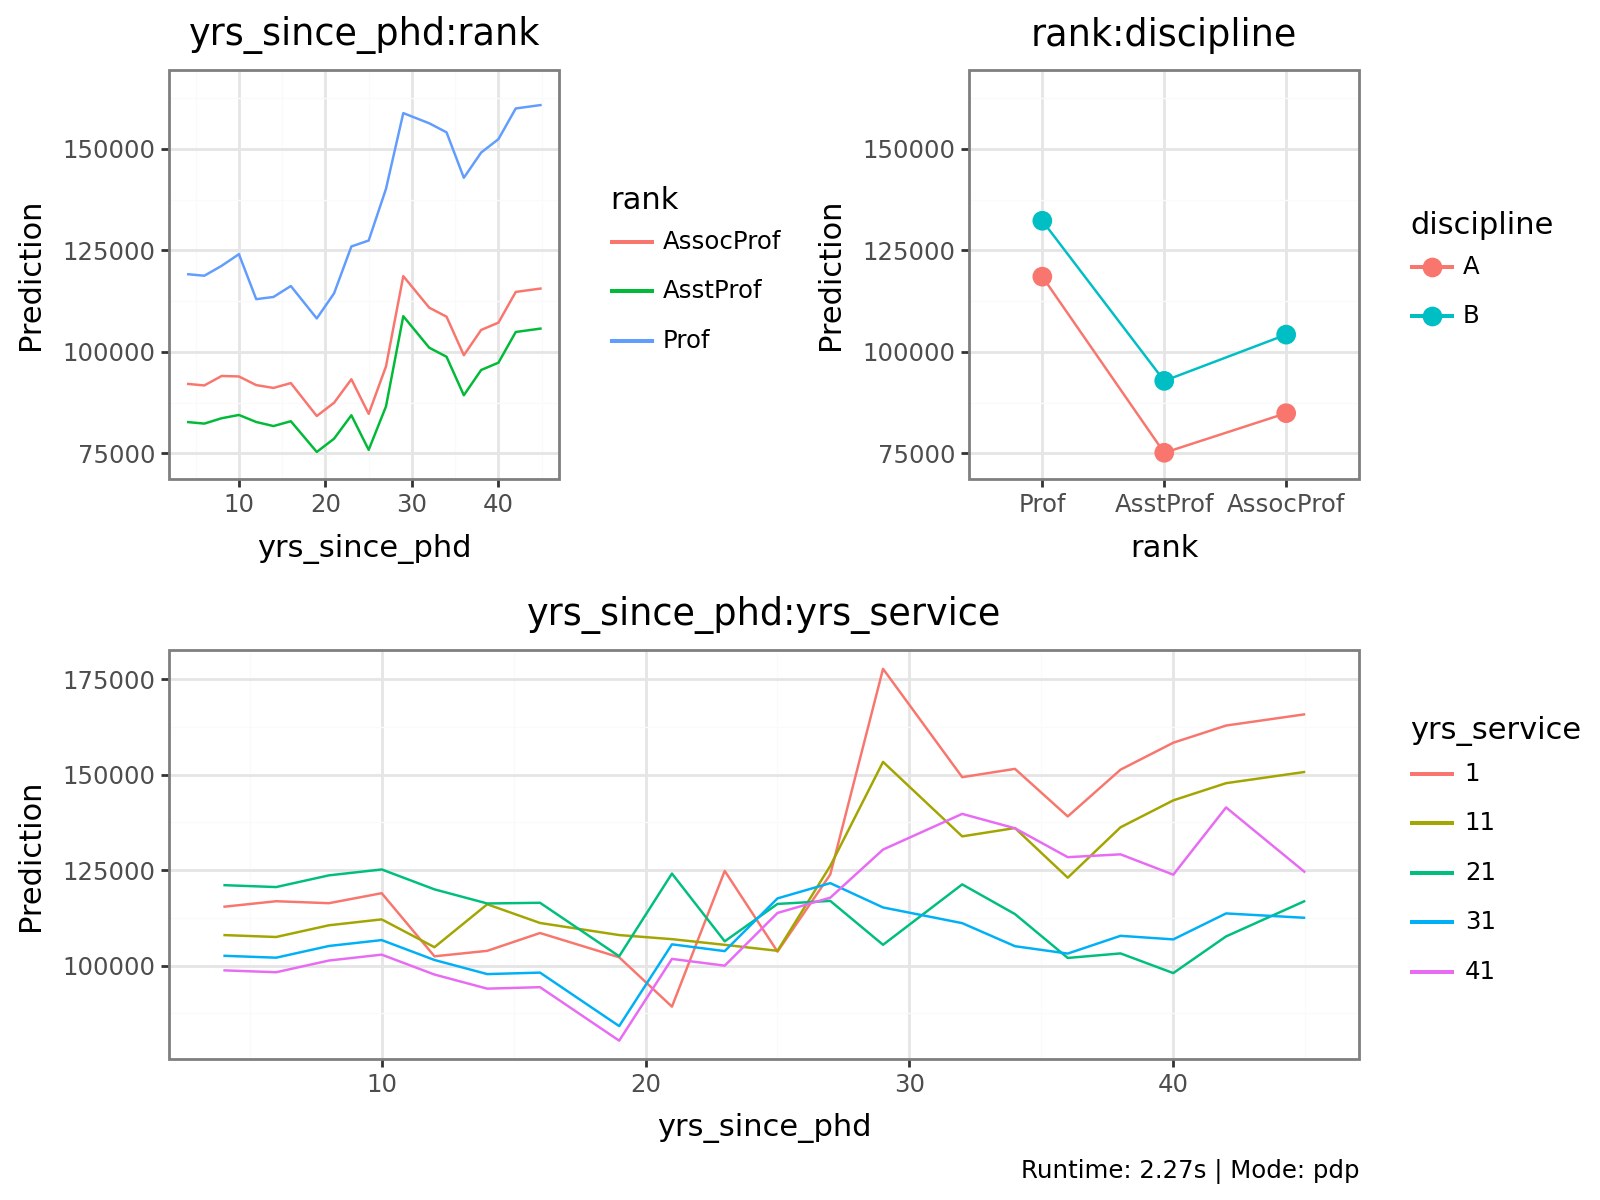

In [22]:
# XGBoost Regression Interactions
plot_xgb_reg_int, _, xgb_reg_int_time = pdp_sk(
    xgb_reg.fitted, salary, incl=[],
    incl_int=["yrs_since_phd:rank", "rank:discipline", "yrs_since_phd:yrs_service"],
    mode="pdp", n_sample=300, grid_resolution=20
)
print(f"XGBoost Regression Interactions: {xgb_reg_int_time:.3f}s")
plot_xgb_reg_int

---
# 3. MLP Neural Network

## 3a. MLP Classification

In [23]:
mlp_clf = mlp(
    data=titanic.to_pandas(),
    rvar="survived", lev="Yes", evar=clf_evars,
    mod_type="classification", hidden_layer_sizes=(10, 5), activation="tanh", random_state=1234,
)
mlp_clf.summary()

Multi-layer Perceptron (NN)
Data                 : Not provided
Response variable    : survived
Level                : Yes
Explanatory variables: age, sex, pclass, sibsp
Model type           : classification
Nr. of features      : (4, 5)
Nr. of weights       : 121
Nr. of observations  : 1,043
Hidden_layer_sizes   : (10, 5)
Activation function  : tanh
Solver               : lbfgs
Alpha                : 0.0001
Batch size           : auto
Learning rate        : 0.001
Maximum iterations   : 1000000
random_state         : 1234
AUC                  : 0.92

Raw data             :
shape: (5, 4)
┌────────┬────────┬────────┬───────┐
│ age    ┆ sex    ┆ pclass ┆ sibsp │
│ ---    ┆ ---    ┆ ---    ┆ ---   │
│ f64    ┆ cat    ┆ cat    ┆ i32   │
╞════════╪════════╪════════╪═══════╡
│ 29.0   ┆ female ┆ 1st    ┆ 0     │
│ 0.9167 ┆ male   ┆ 1st    ┆ 1     │
│ 2.0    ┆ female ┆ 1st    ┆ 1     │
│ 30.0   ┆ male   ┆ 1st    ┆ 1     │
│ 25.0   ┆ female ┆ 1st    ┆ 1     │
└────────┴────────┴────────┴───────┘

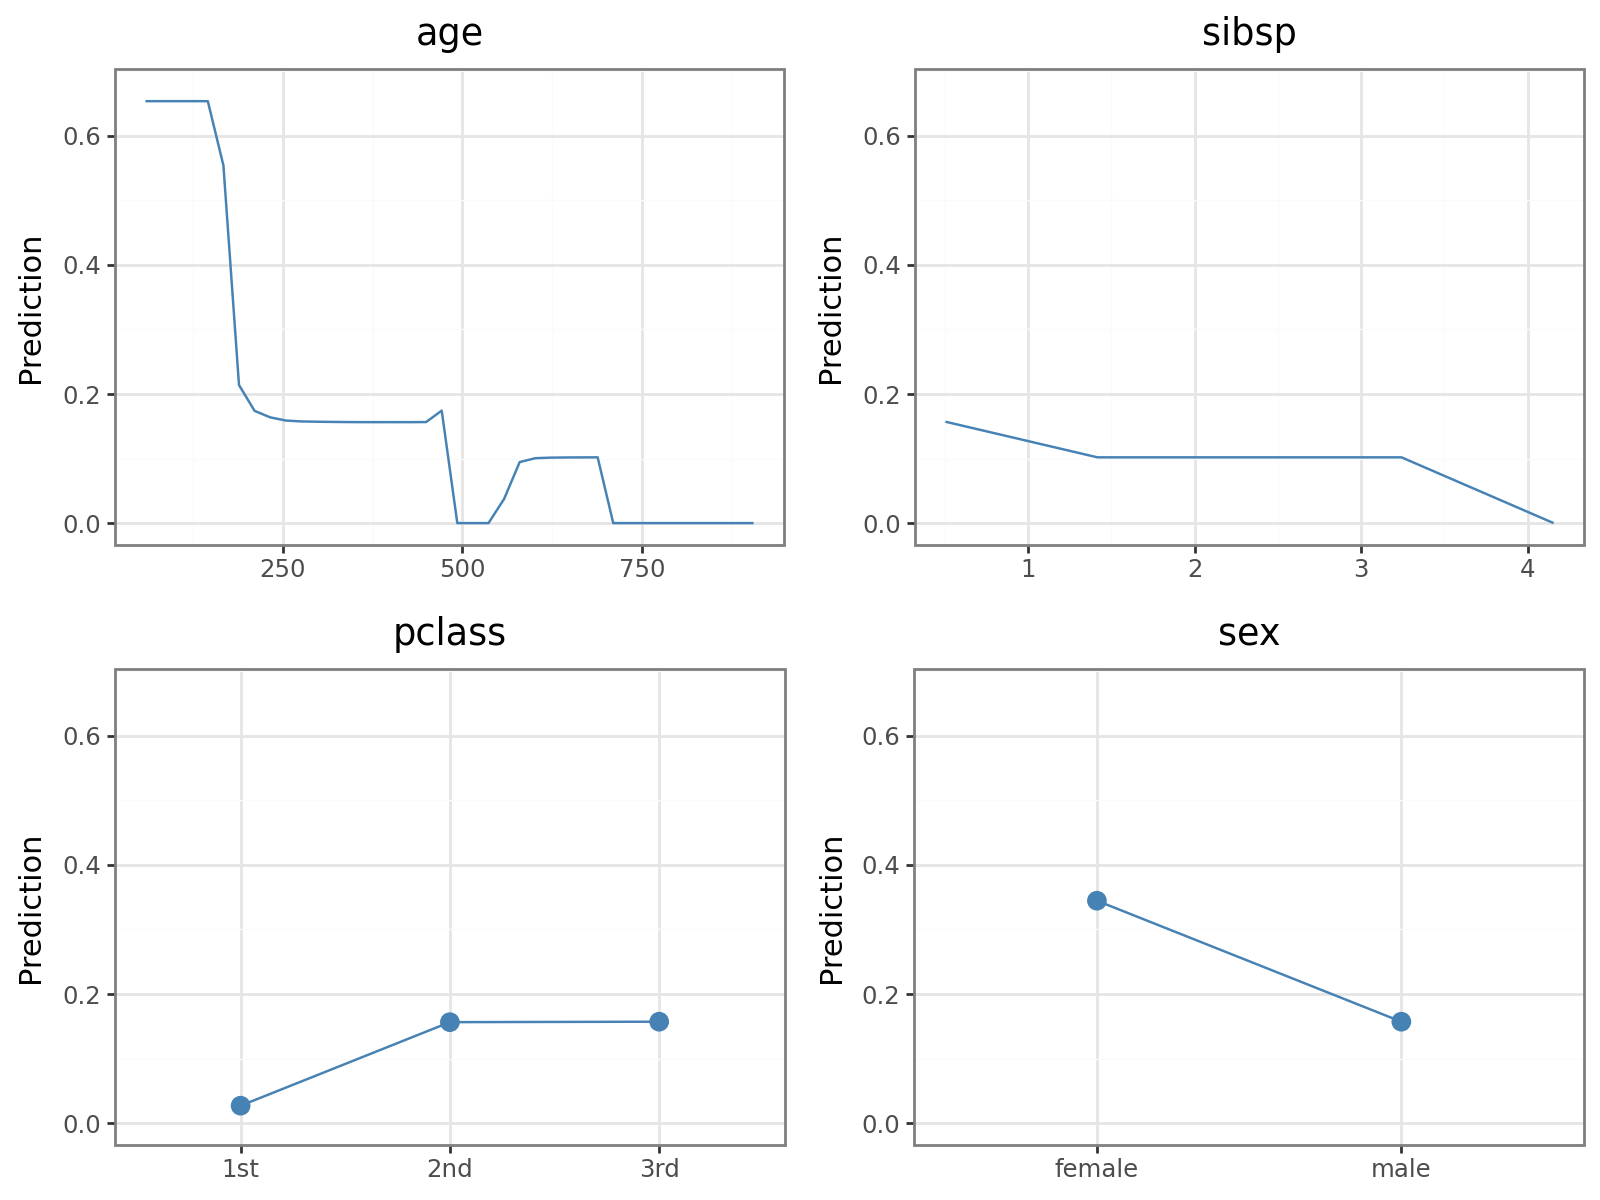

In [24]:
# pred_plot_sk
mlp_clf.plot(plots="pred") #, incl=["pclass", "sex"], nnv=30)

pred_plot_sk: 0.060s


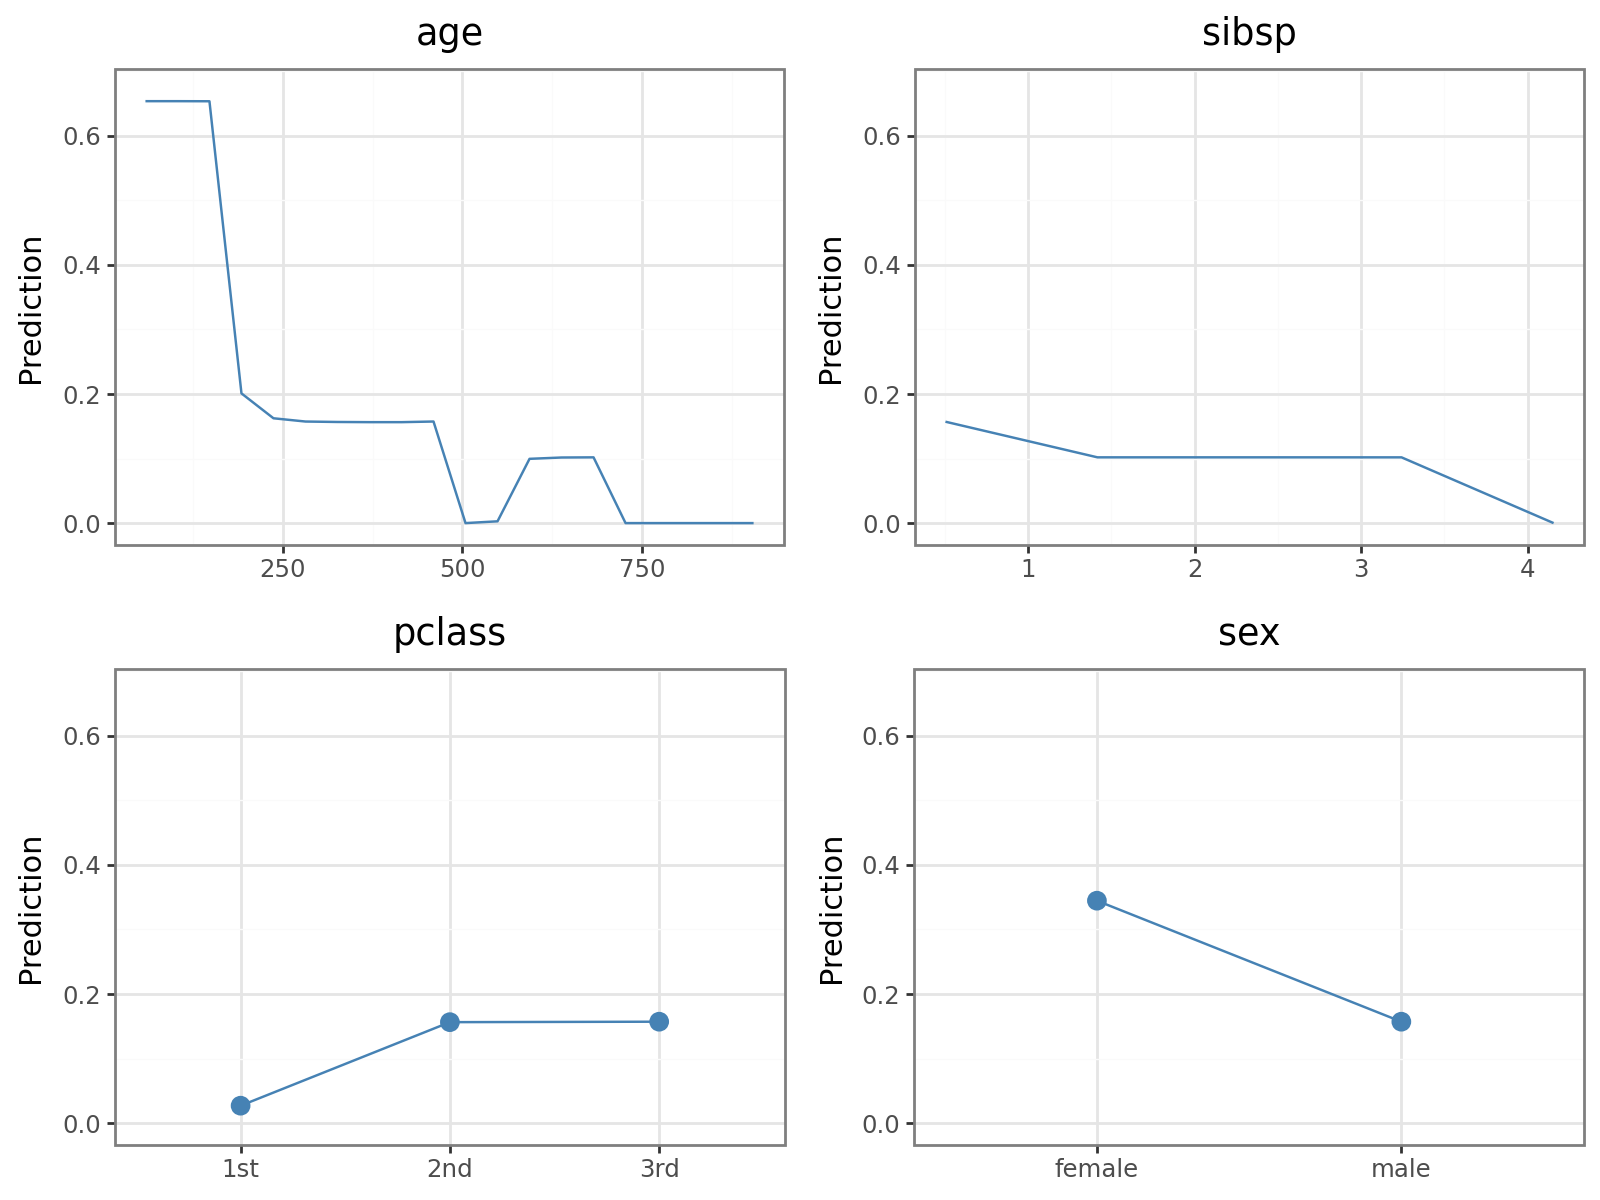

In [25]:
# pred_plot_sk - pass full mlp object for scaling
start = time.time()
plot_mlp_pred = pred_plot_sk(mlp_clf, titanic)
mlp_clf_pred_time = time.time() - start
print(f"pred_plot_sk: {mlp_clf_pred_time:.3f}s")
plot_mlp_pred

pdp_sk (fast): 0.041s


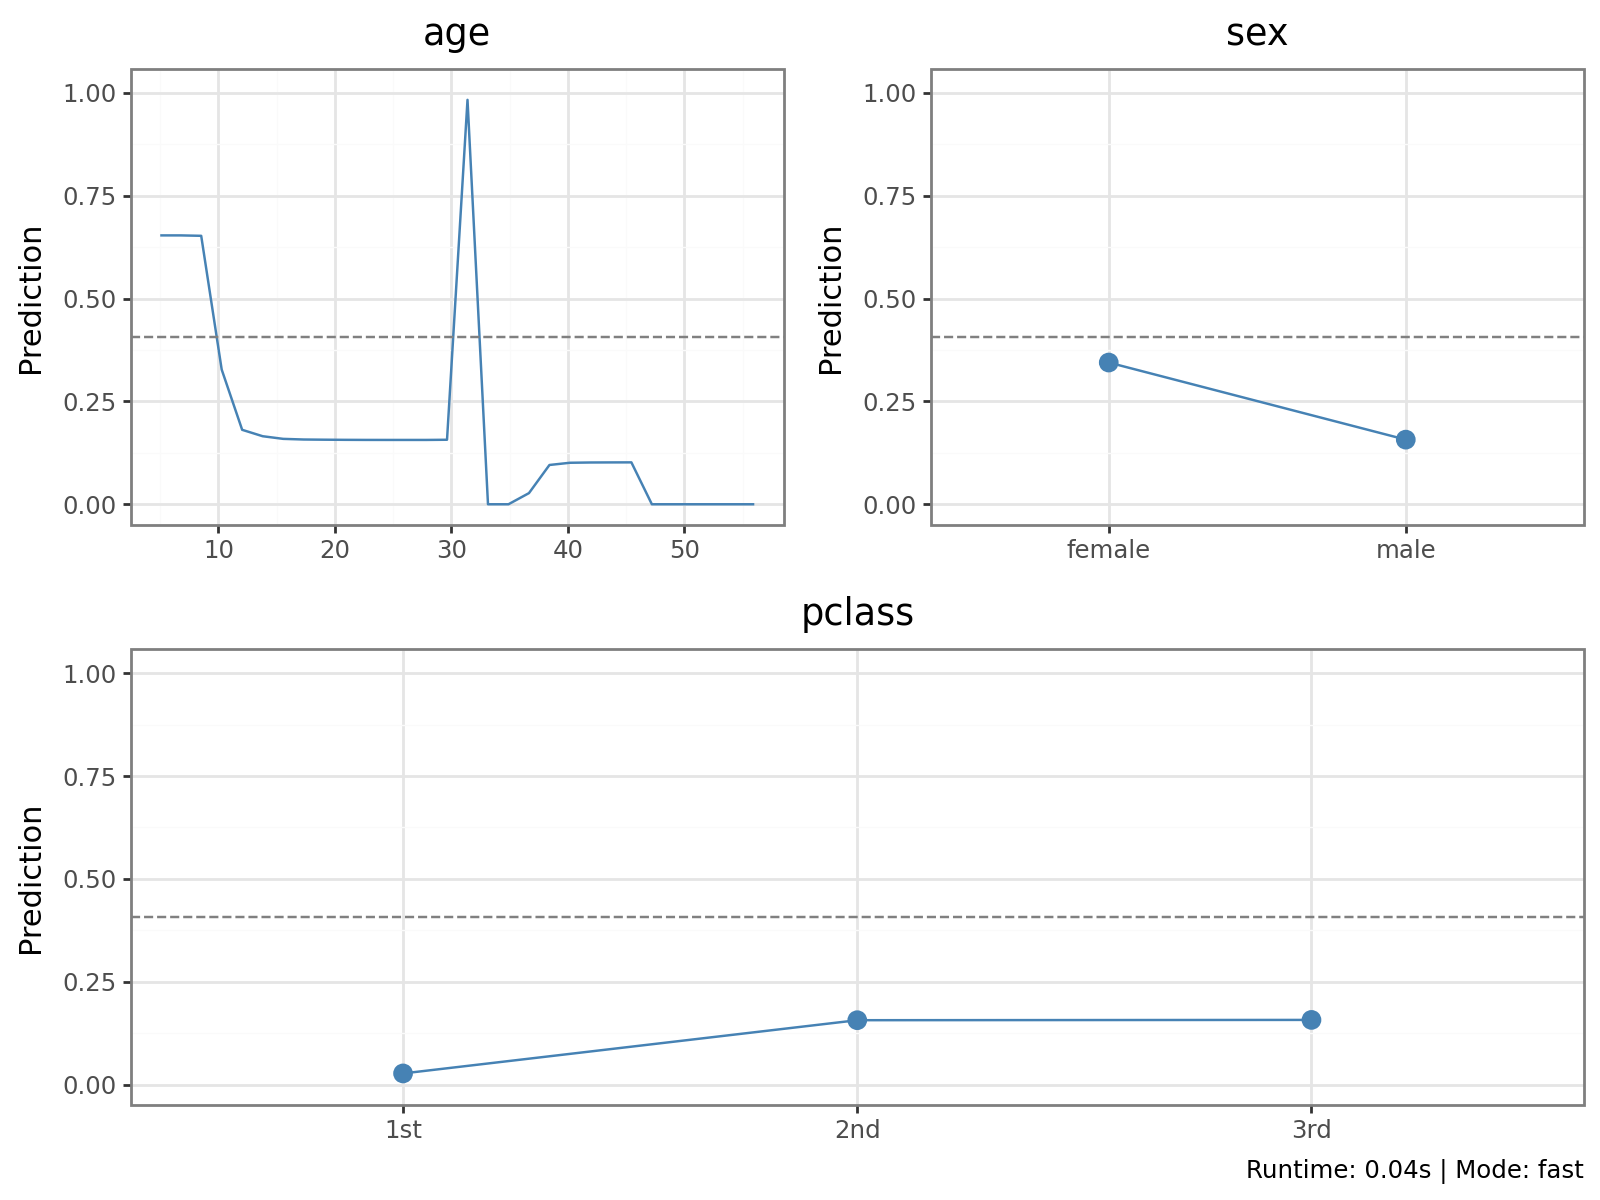

In [26]:
# pdp_sk - Fast - pass full mlp object for scaling
plot_mlp_fast, _, mlp_clf_fast_time = pdp_sk(
    mlp_clf, titanic, incl=["age", "sex", "pclass"], mode="fast", grid_resolution=30
)
print(f"pdp_sk (fast): {mlp_clf_fast_time:.3f}s")
plot_mlp_fast

pdp_sk (pdp): 0.139s


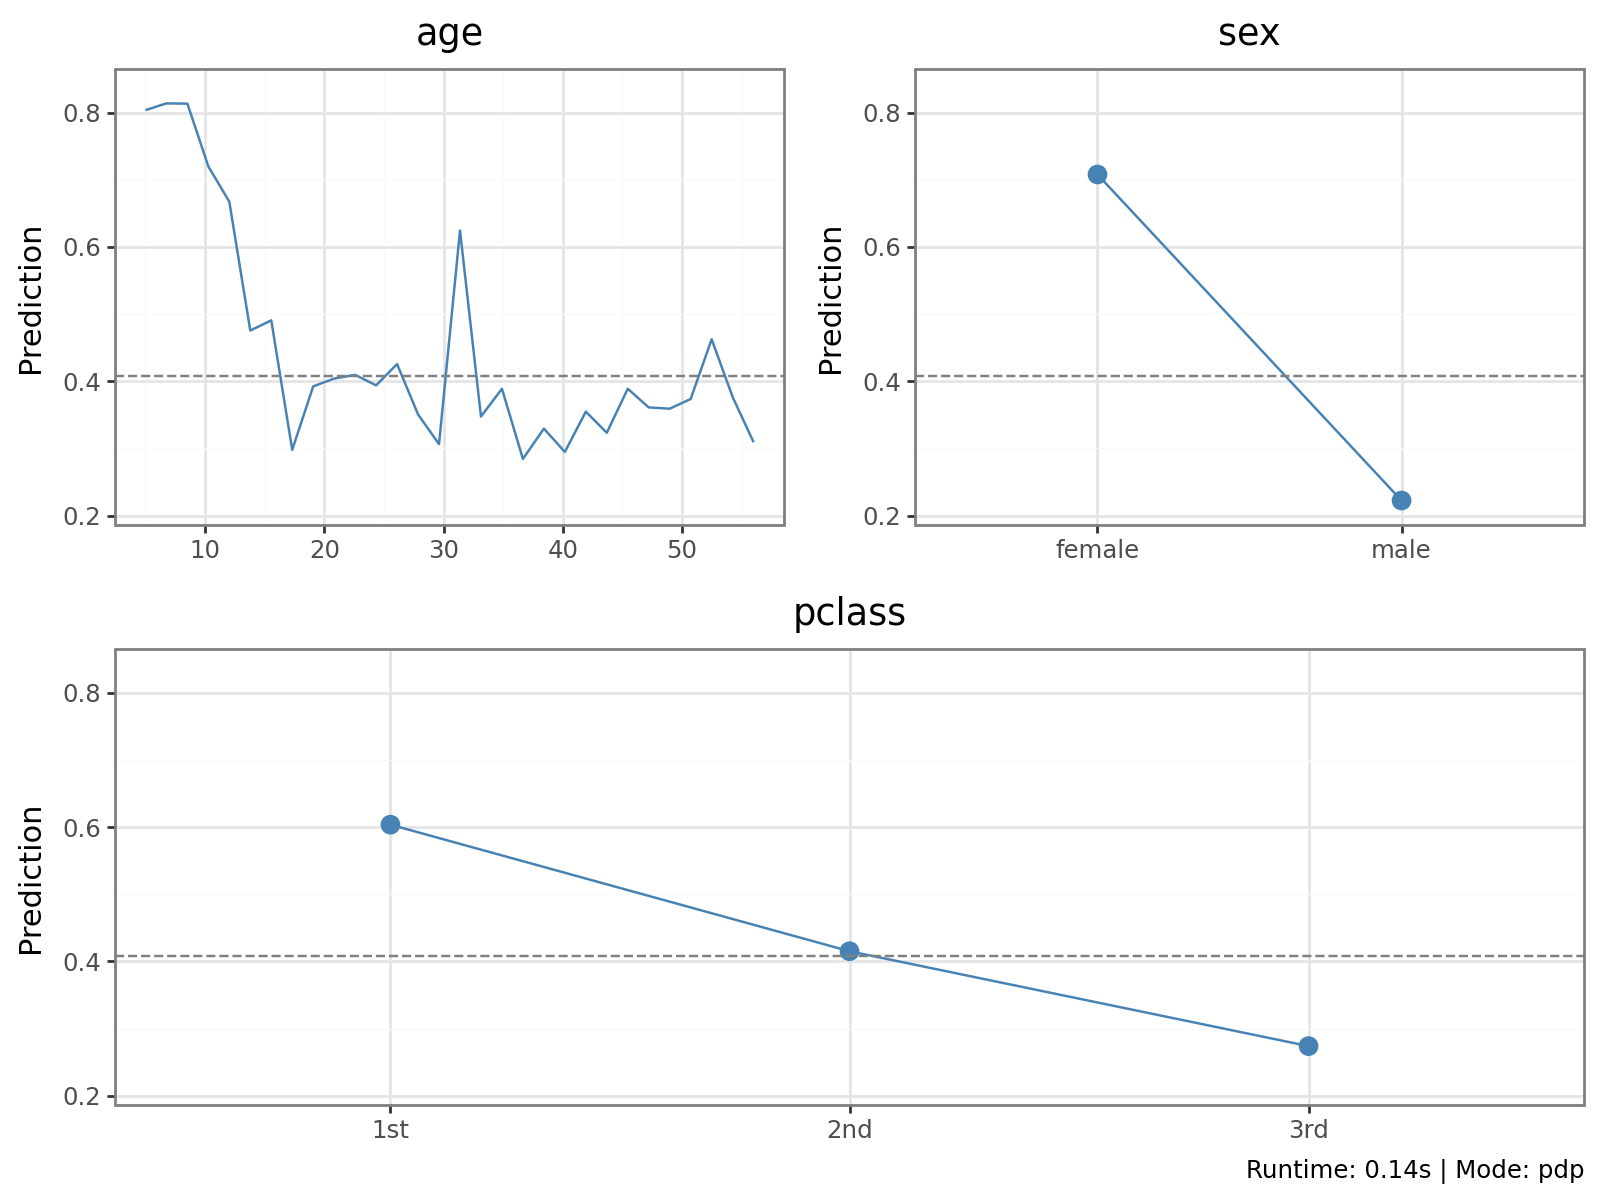

In [27]:
# pdp_sk - PDP - pass full mlp object for scaling
plot_mlp_pdp, _, mlp_clf_pdp_time = pdp_sk(
    mlp_clf, titanic, incl=["age", "sex", "pclass"], mode="pdp", n_sample=500, grid_resolution=30
)
print(f"pdp_sk (pdp): {mlp_clf_pdp_time:.3f}s")
plot_mlp_pdp

MLP Classification Interactions: 0.532s


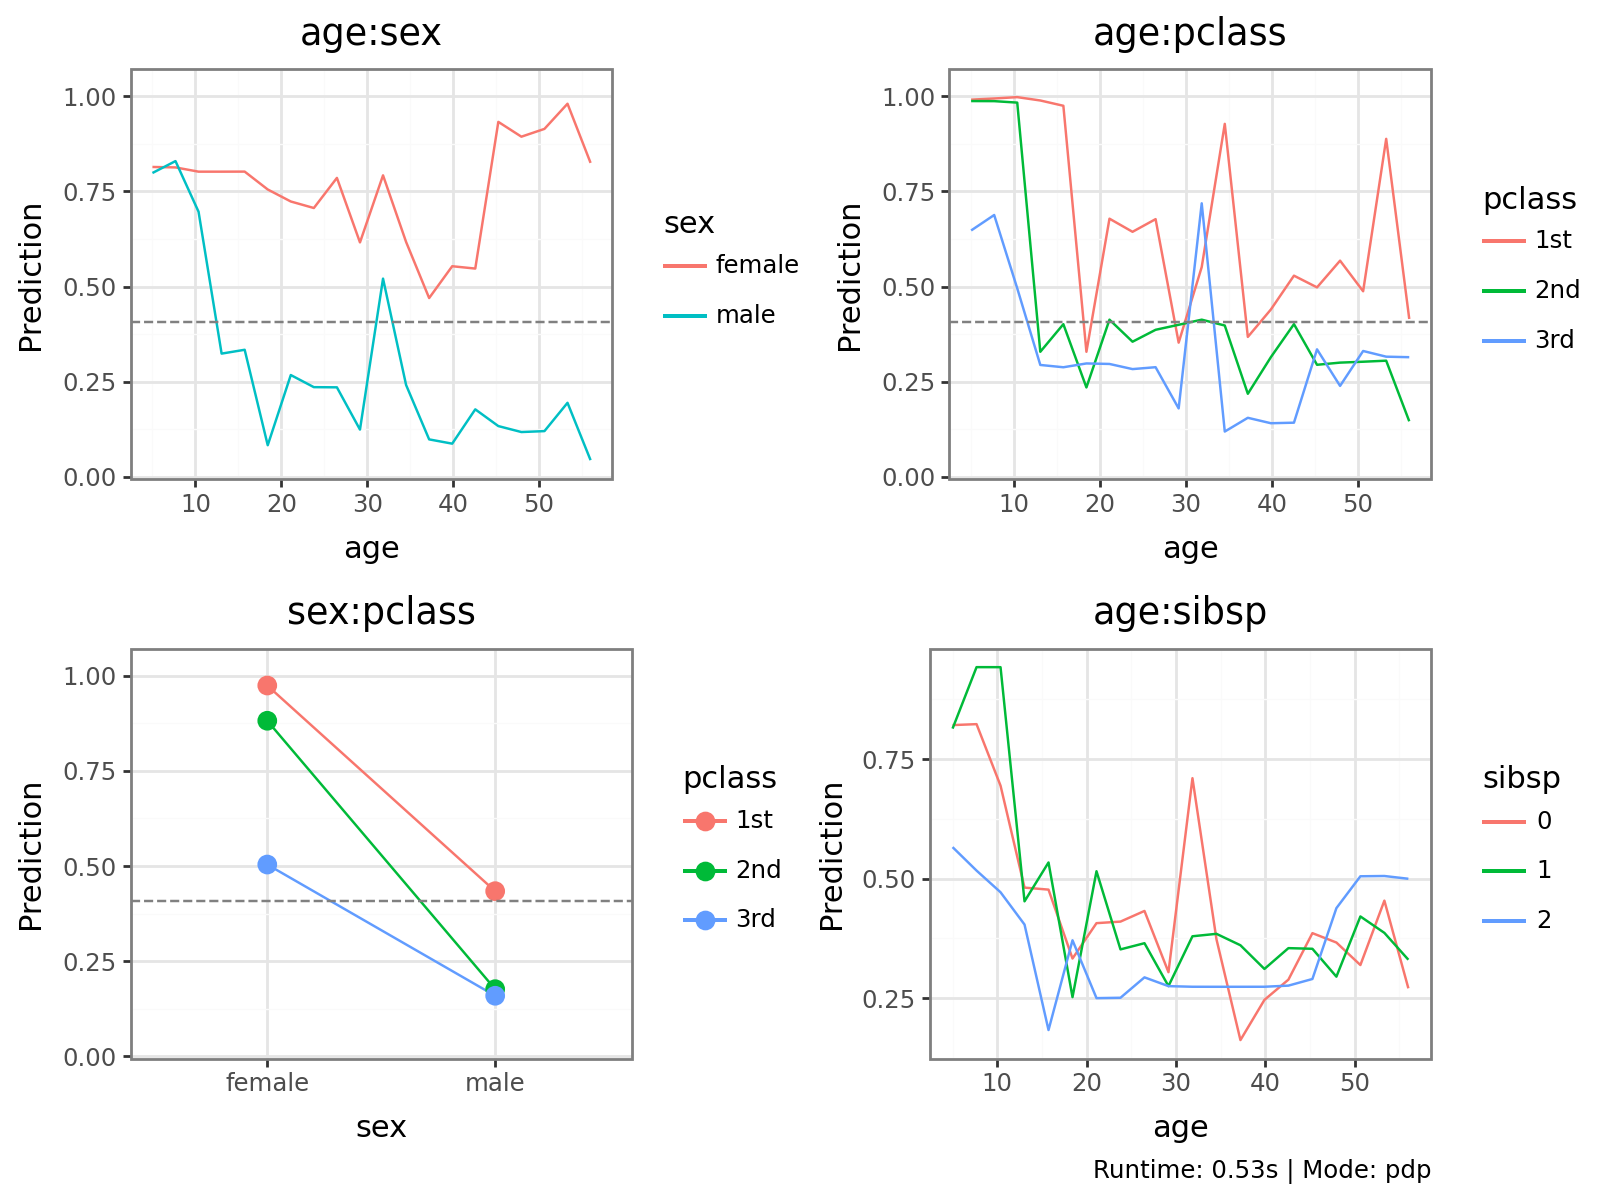

In [28]:
# MLP Classification Interactions - pass full mlp object for scaling
plot_mlp_clf_int, _, mlp_clf_int_time = pdp_sk(
    mlp_clf, titanic, incl=[],
    incl_int=["age:sex", "age:pclass", "sex:pclass", "age:sibsp"],
    mode="pdp", n_sample=300, grid_resolution=20
)
print(f"MLP Classification Interactions: {mlp_clf_int_time:.3f}s")
plot_mlp_clf_int

## 3b. MLP Regression

In [29]:
mlp_reg = mlp(
    data=salary.to_pandas(),
    rvar="salary", evar=reg_evars,
    mod_type="regression", hidden_layer_sizes=(2, 2), activation="tanh", random_state=1234,
)
mlp_reg.summary()

Multi-layer Perceptron (NN)
Data                 : Not provided
Response variable    : salary
Explanatory variables: yrs_since_phd, yrs_service, rank, discipline
Model type           : regression
Nr. of features      : (4, 5)
Nr. of weights       : 21
Nr. of observations  : 397
Hidden_layer_sizes   : (2, 2)
Activation function  : tanh
Solver               : lbfgs
Alpha                : 0.0001
Batch size           : auto
Learning rate        : 0.001
Maximum iterations   : 1000000
random_state         : 1234
Model fit            :
    n     r2    mse    mae
  397  0.543  0.457  0.495

Raw data             :
shape: (5, 4)
┌───────────────┬─────────────┬──────────┬────────────┐
│ yrs_since_phd ┆ yrs_service ┆ rank     ┆ discipline │
│ ---           ┆ ---         ┆ ---      ┆ ---        │
│ i32           ┆ i32         ┆ cat      ┆ cat        │
╞═══════════════╪═════════════╪══════════╪════════════╡
│ 19            ┆ 18          ┆ Prof     ┆ B          │
│ 20            ┆ 16          ┆ Prof 

pdp_sk regression: 0.202s


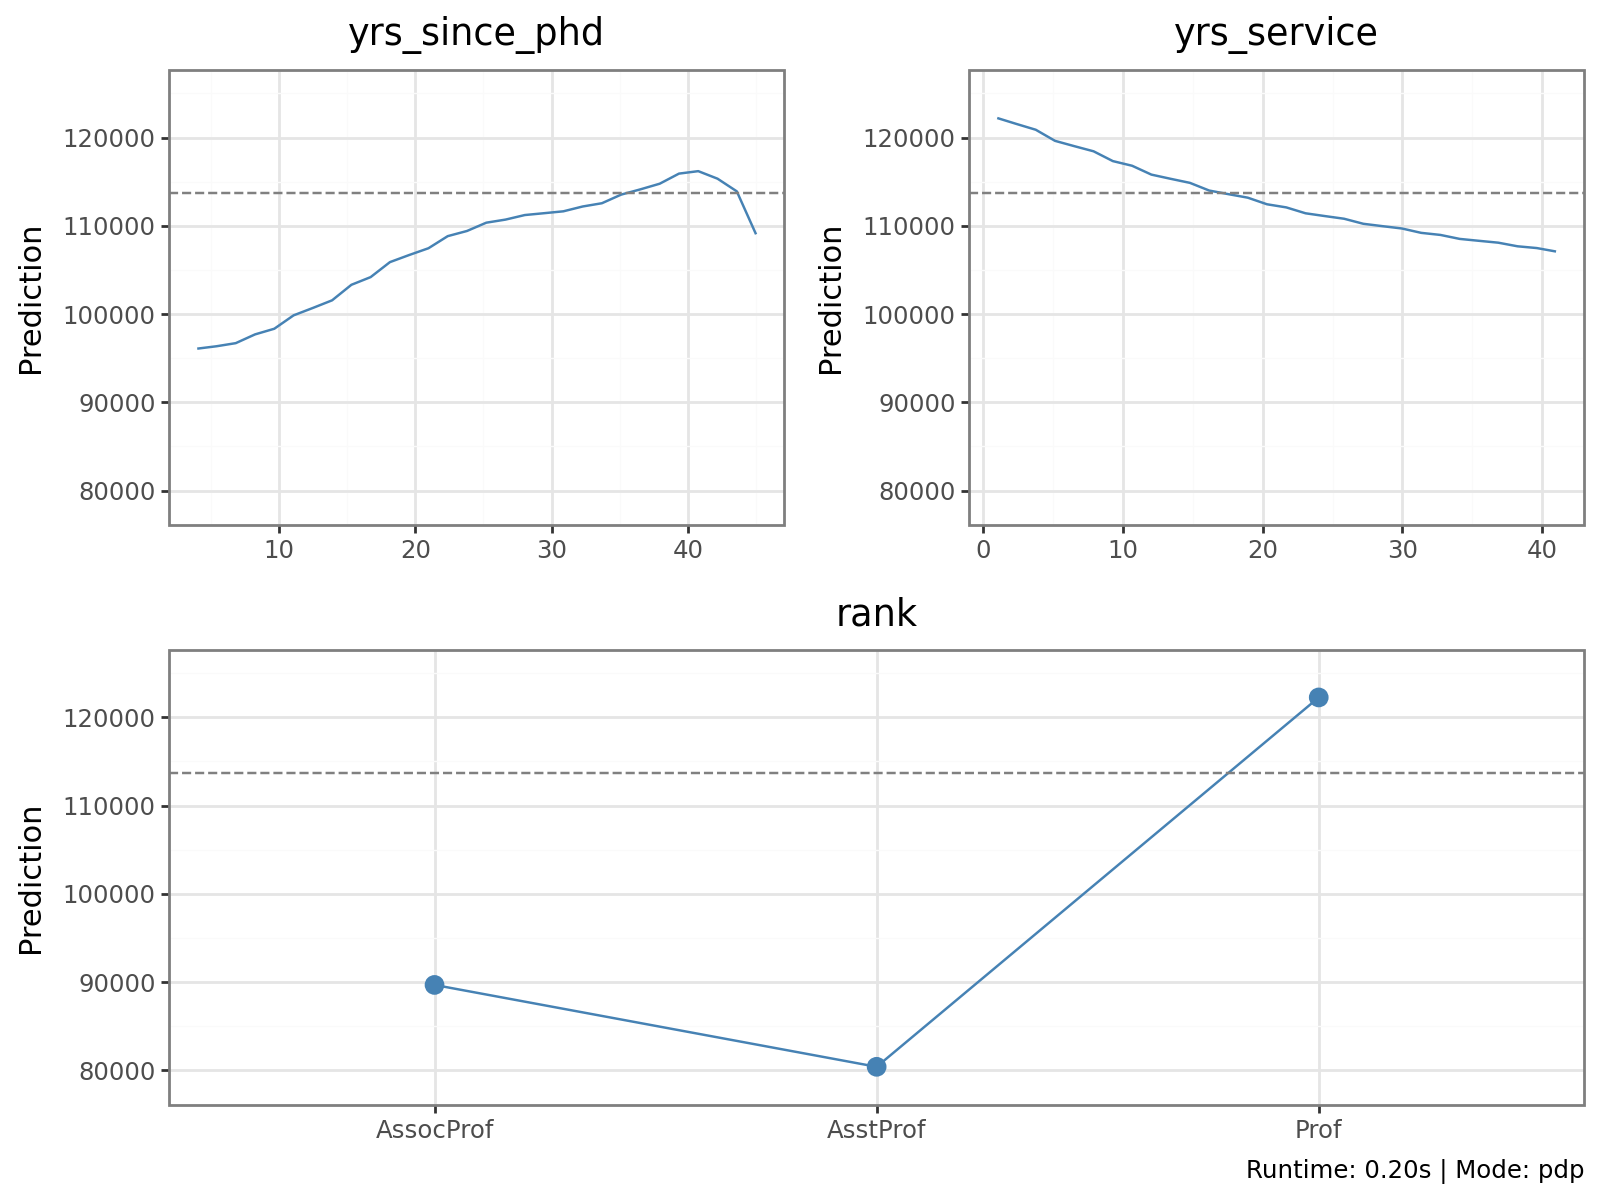

In [30]:
# pdp_sk - pass full mlp object for scaling
plot_mlp_reg, _, mlp_reg_pdp_time = pdp_sk(
    mlp_reg, salary, incl=["yrs_since_phd", "yrs_service", "rank"],
    mode="pdp", n_sample=300, grid_resolution=30
)
print(f"pdp_sk regression: {mlp_reg_pdp_time:.3f}s")
plot_mlp_reg

MLP Regression Interactions: 0.413s


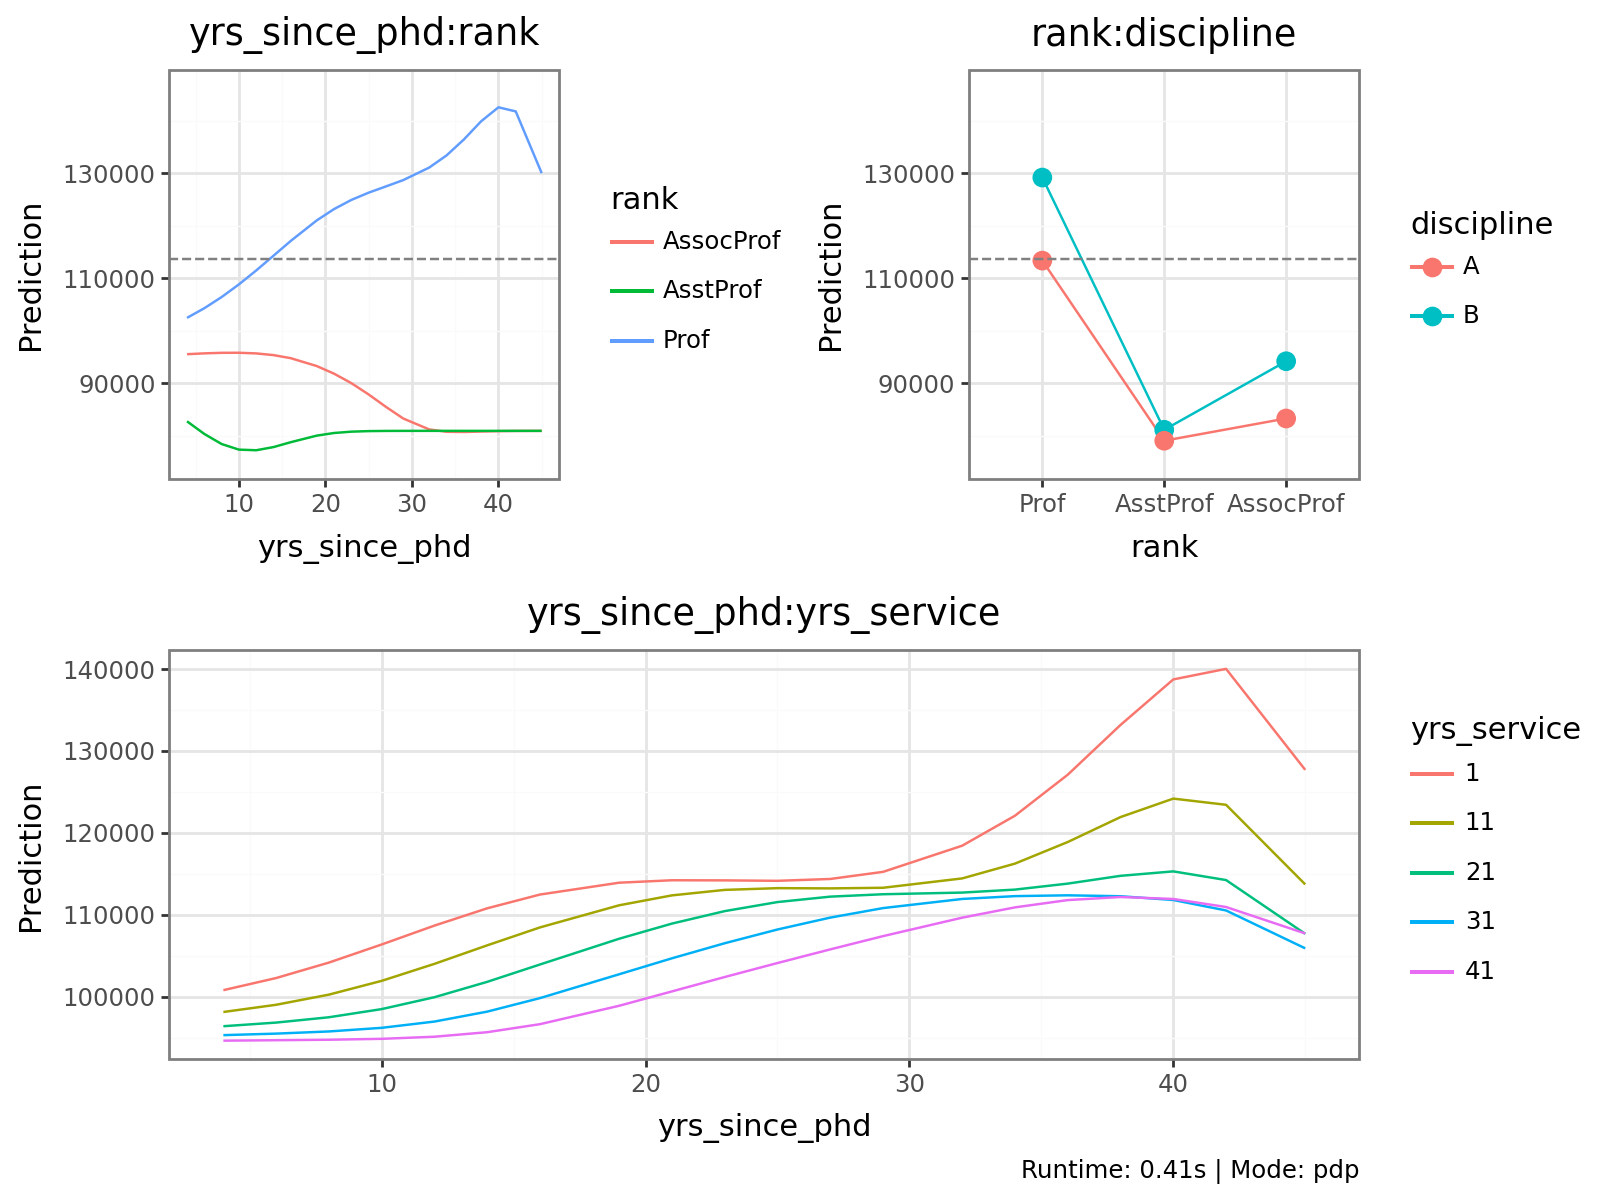

In [31]:
# MLP Regression Interactions - pass full mlp object for scaling
plot_mlp_reg_int, _, mlp_reg_int_time = pdp_sk(
    mlp_reg, salary, incl=[],
    incl_int=["yrs_since_phd:rank", "rank:discipline", "yrs_since_phd:yrs_service"],
    mode="pdp", n_sample=300, grid_resolution=20
)
print(f"MLP Regression Interactions: {mlp_reg_int_time:.3f}s")
plot_mlp_reg_int

# Logistic Regression Interactions - all types
plot_log_int, _, log_int_time = pdp_sm(
    log_model.fitted, titanic, incl=[],
    incl_int=["age:sex", "age:pclass", "sex:pclass", "age:sibsp"],
    mode="pdp", n_sample=300, grid_resolution=20
)
print(f"Logistic Regression Interactions: {log_int_time:.3f}s")
plot_log_int

In [32]:
log_model = logistic(
    data=titanic,
    rvar="survived", lev="Yes", evar=clf_evars,
)
log_model.summary()

Logistic regression (GLM)
Data                 : Not provided
Response variable    : survived
Level                : Yes
Explanatory variables: age, sex, pclass, sibsp
Null hyp.: There is no effect of x on survived
Alt. hyp.: There is an effect of x on survived

┌─────────────┬────────┬─────────┬─────────────┬───────────┬─────────┬─────────┬─────┐
│ index       ┆ OR     ┆ OR%     ┆ coefficient ┆ std.error ┆ z.value ┆ p.value ┆     │
╞═════════════╪════════╪═════════╪═════════════╪═══════════╪═════════╪═════════╪═════╡
│ Intercept   ┆ 51.376 ┆ 5037.6% ┆ 3.939       ┆ 0.358     ┆ 10.998  ┆ < .001  ┆ *** │
│ sex[male]   ┆ 0.076  ┆ -92.4%  ┆ -2.574      ┆ 0.171     ┆ -15.062 ┆ < .001  ┆ *** │
│ pclass[2nd] ┆ 0.256  ┆ -74.4%  ┆ -1.363      ┆ 0.23      ┆ -5.928  ┆ < .001  ┆ *** │
│ pclass[3rd] ┆ 0.096  ┆ -90.4%  ┆ -2.344      ┆ 0.229     ┆ -10.249 ┆ < .001  ┆ *** │
│ age         ┆ 0.961  ┆ -3.9%   ┆ -0.04       ┆ 0.007     ┆ -5.989  ┆ < .001  ┆ *** │
│ sibsp       ┆ 0.721  ┆ -27.9%  ┆ -0.328

pred_plot_sm: 0.080s


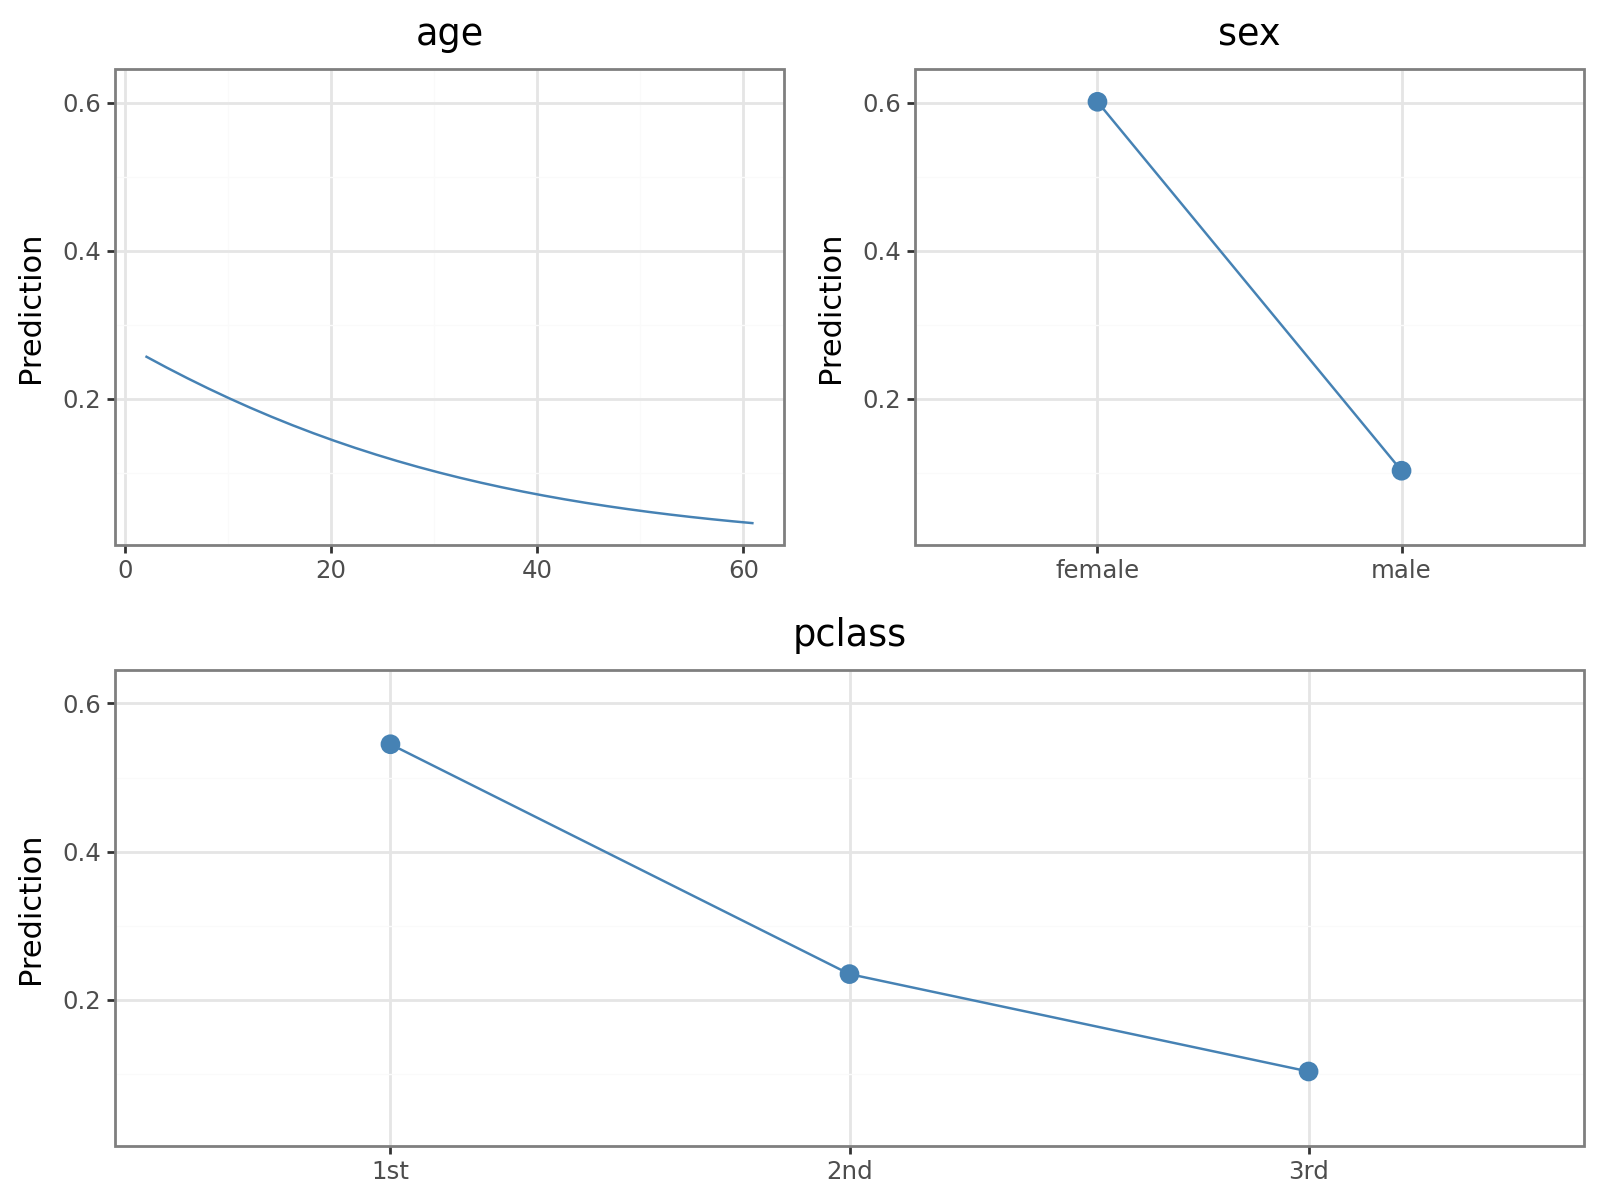

In [33]:
# pred_plot_sm (existing)
start = time.time()
plot_log_pred = pred_plot_sm(log_model.fitted, titanic, incl=["age", "sex", "pclass"], nnv=30)
log_pred_time = time.time() - start
print(f"pred_plot_sm: {log_pred_time:.3f}s")
plot_log_pred

pdp_sm (fast): 0.054s


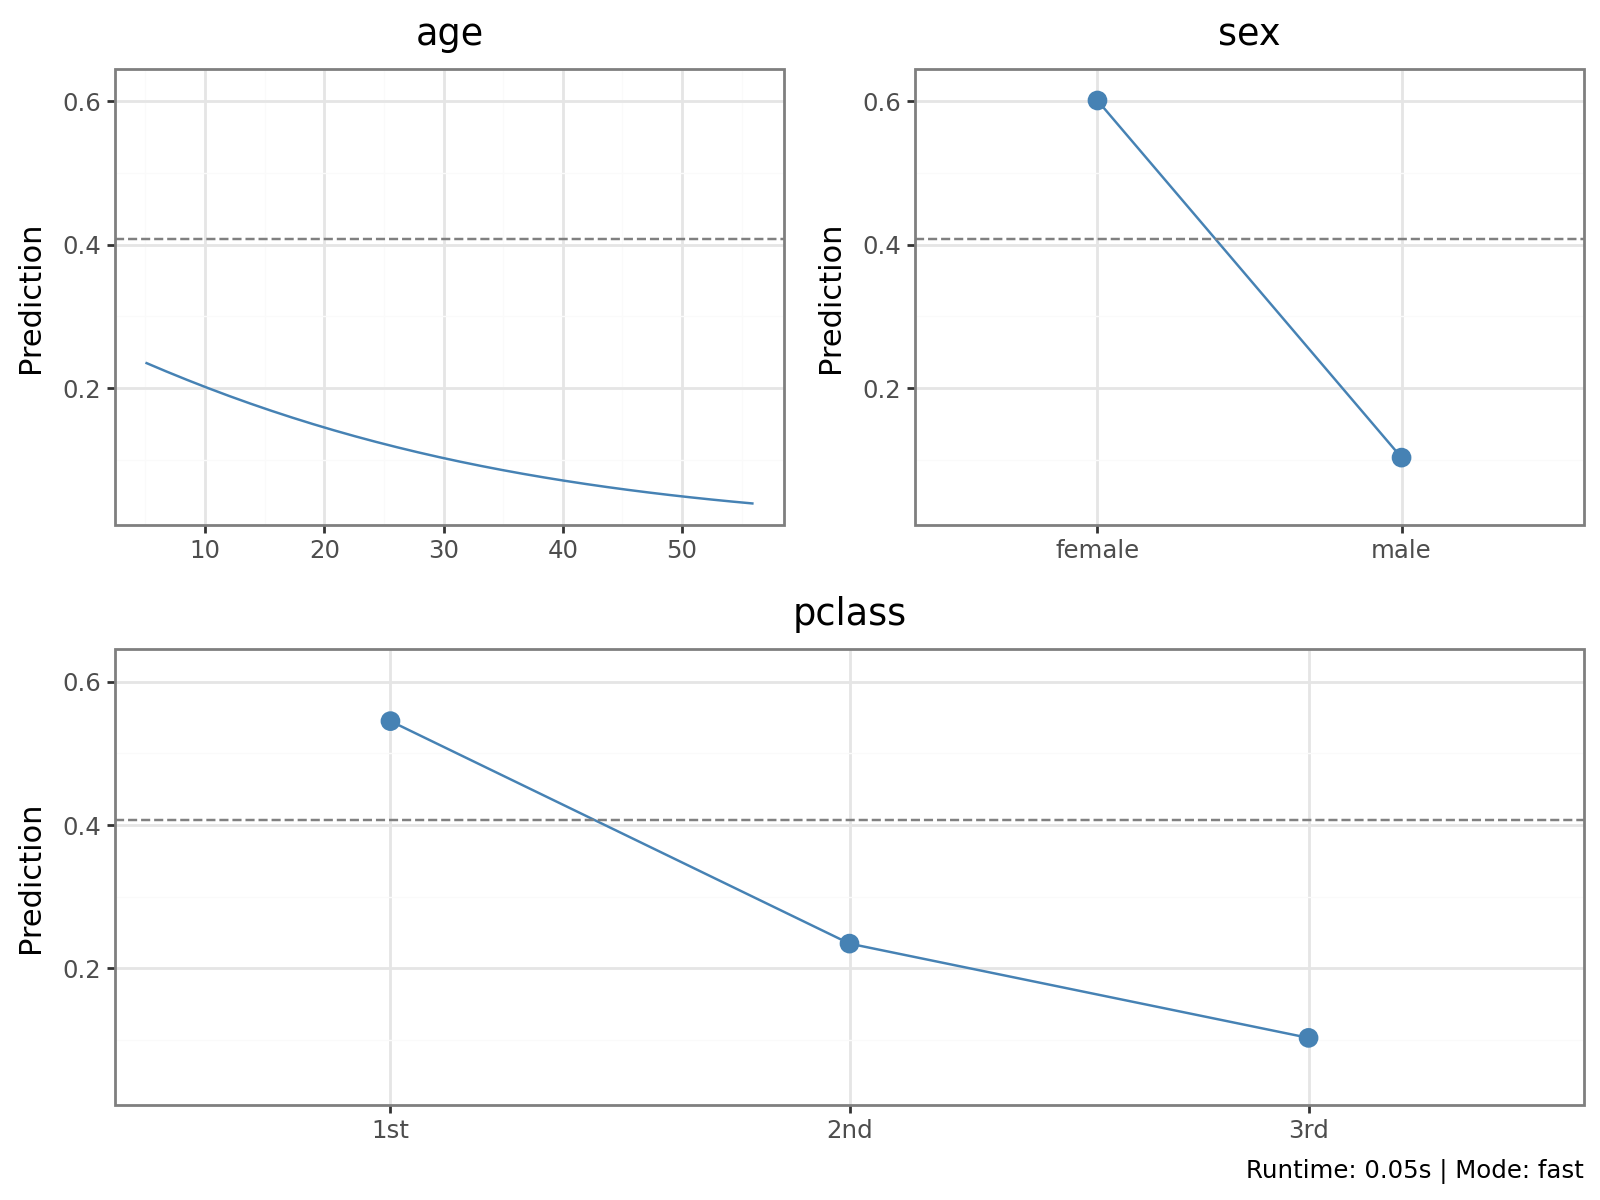

In [34]:
# pdp_sm - Fast
plot_log_fast, _, log_fast_time = pdp_sm(
    log_model.fitted, titanic, incl=["age", "sex", "pclass"], mode="fast", grid_resolution=30
)
print(f"pdp_sm (fast): {log_fast_time:.3f}s")
plot_log_fast

pdp_sm (pdp): 0.262s


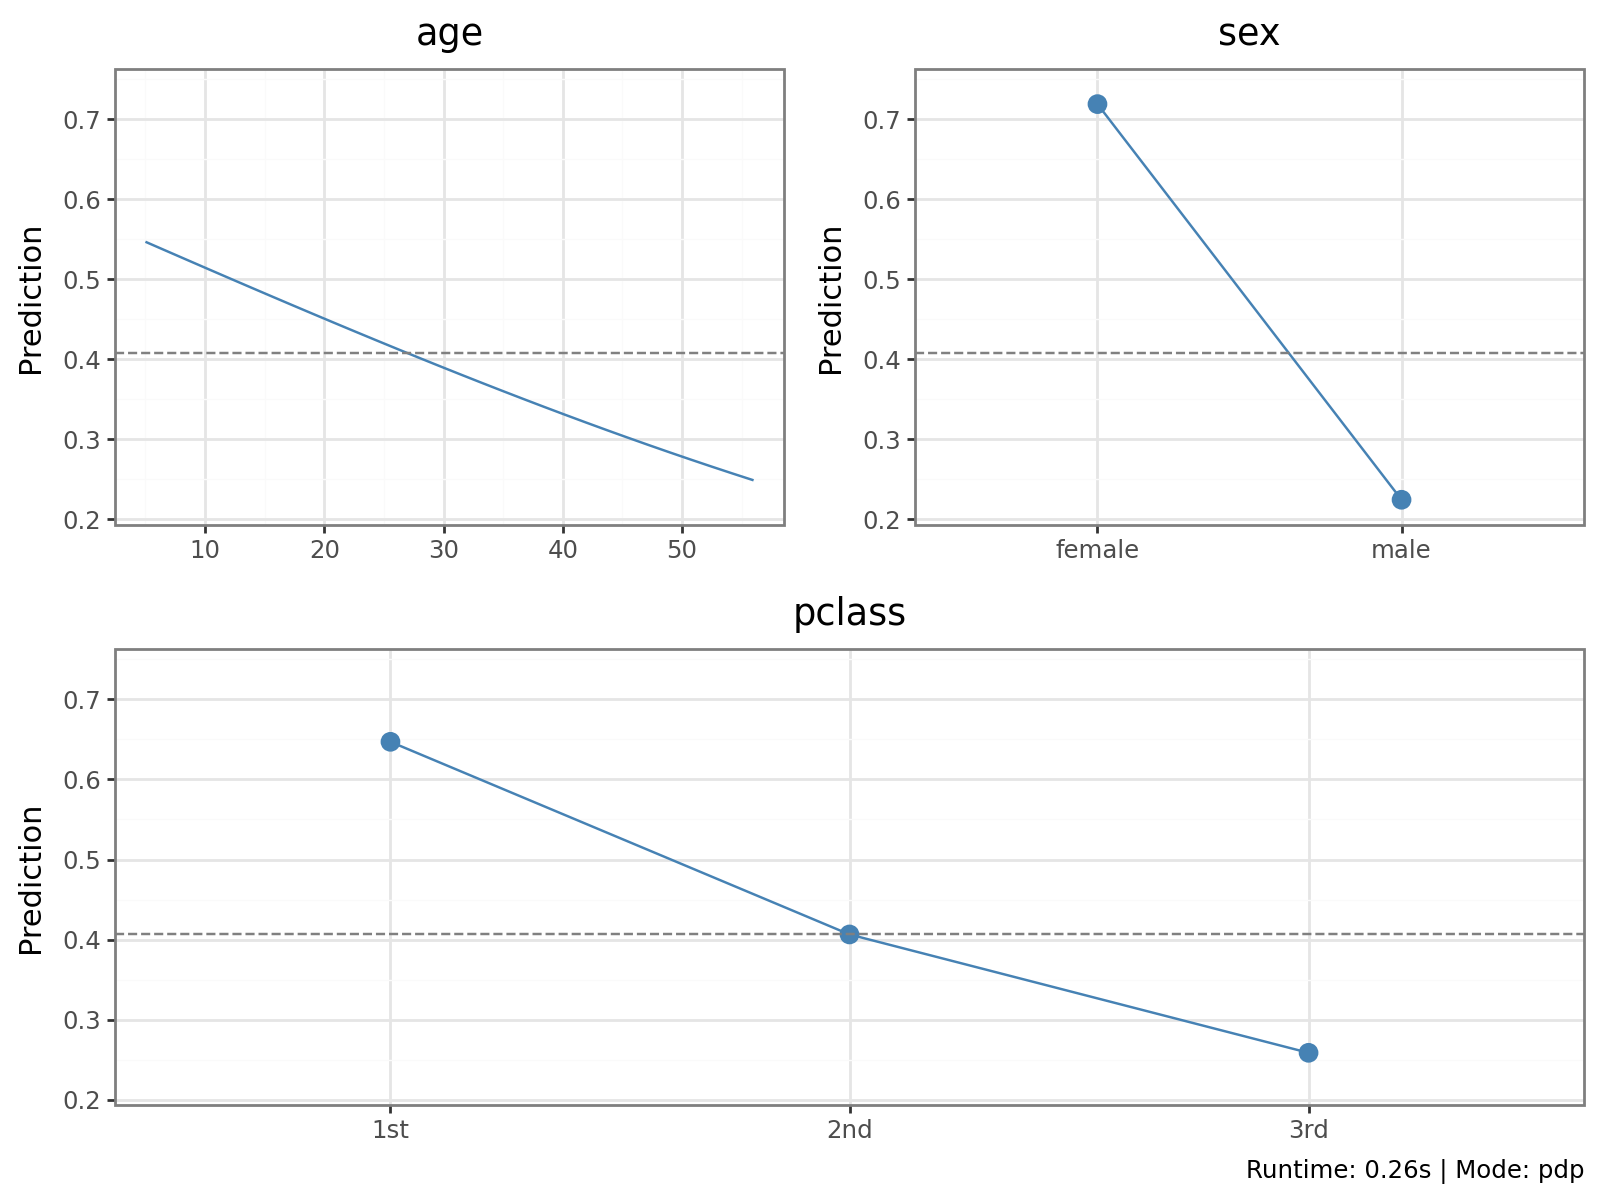

In [35]:
# pdp_sm - PDP
plot_log_pdp, _, log_pdp_time = pdp_sm(
    log_model.fitted, titanic, incl=["age", "sex", "pclass"], mode="pdp", n_sample=500, grid_resolution=30
)
print(f"pdp_sm (pdp): {log_pdp_time:.3f}s")
plot_log_pdp

Logistic Regression Interactions: 1.616s


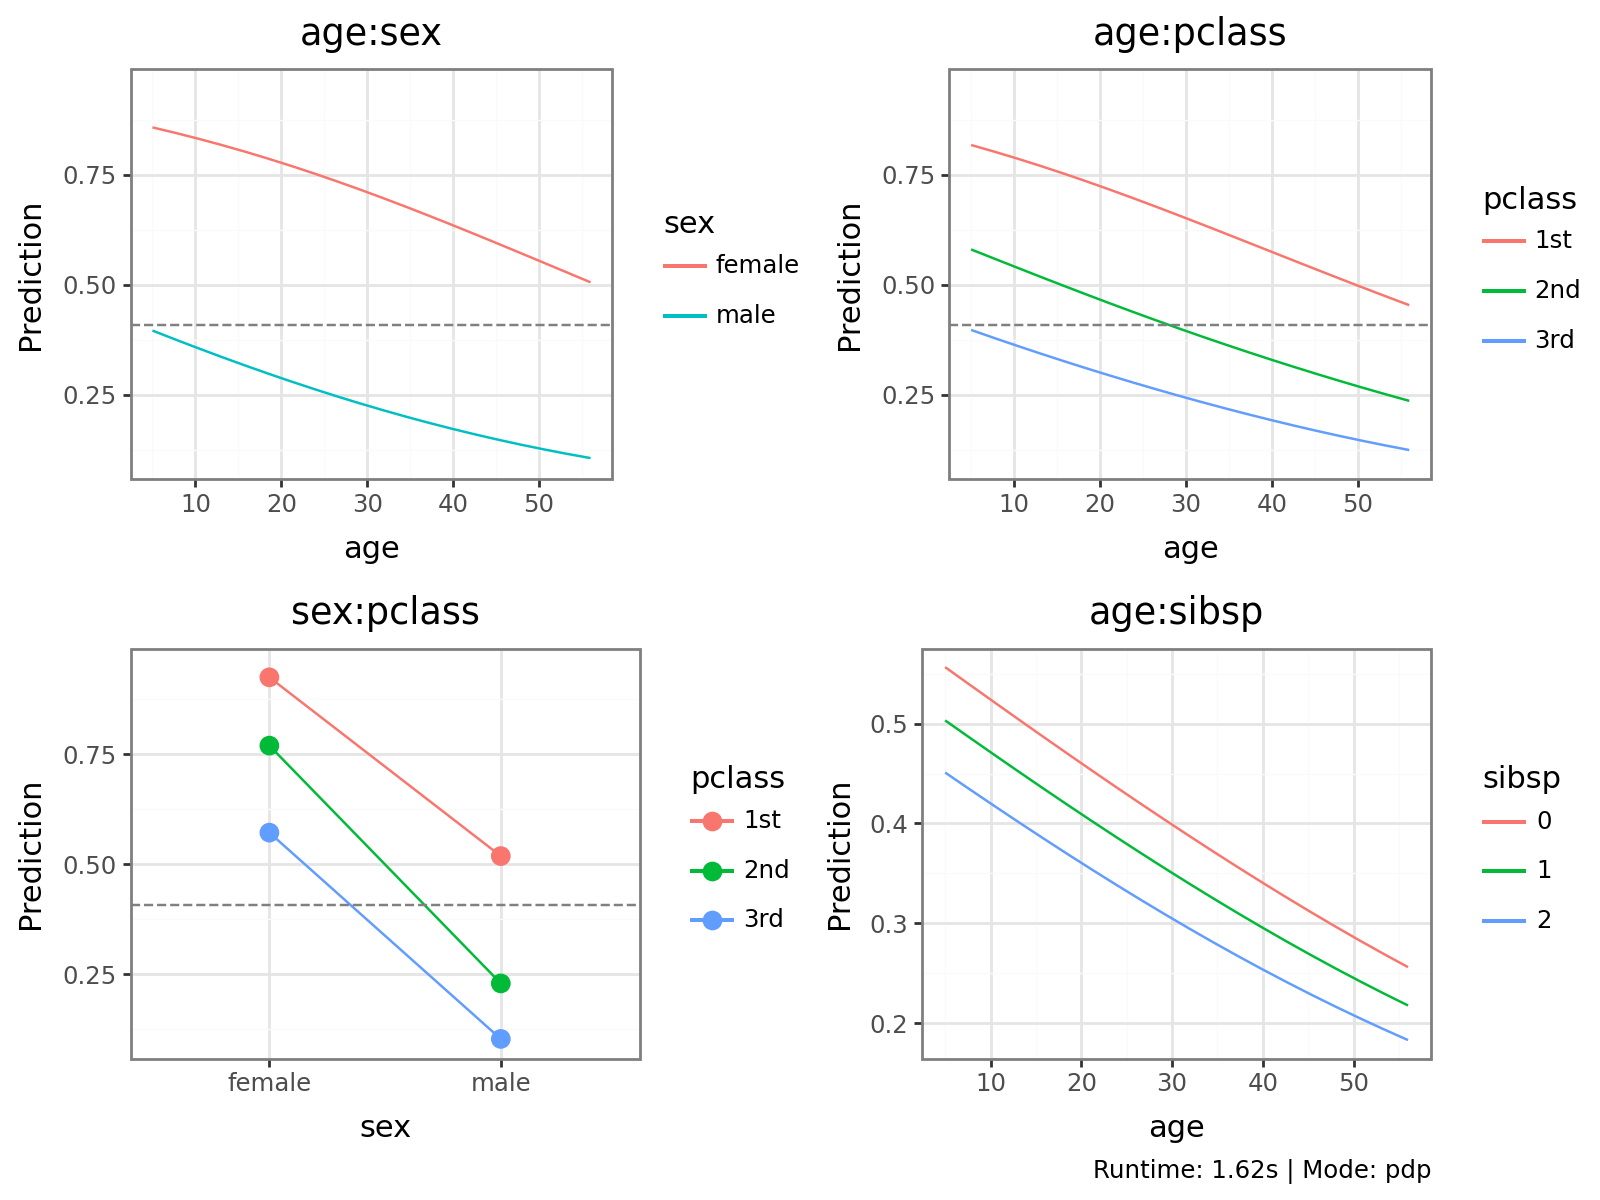

In [36]:
# Logistic Regression Interactions - all types
plot_log_int, _, log_int_time = pdp_sm(
    log_model.fitted, titanic, incl=[],
    incl_int=["age:sex", "age:pclass", "sex:pclass", "age:sibsp"],
    mode="pdp", n_sample=300, grid_resolution=20
)
print(f"Logistic Regression Interactions: {log_int_time:.3f}s")
plot_log_int

# OLS Regression Interactions - all types
plot_ols_int, _, ols_int_time = pdp_sm(
    ols_model.fitted, salary, incl=[],
    incl_int=["yrs_since_phd:rank", "rank:discipline", "yrs_since_phd:yrs_service"],
    mode="pdp", n_sample=300, grid_resolution=20
)
print(f"OLS Regression Interactions: {ols_int_time:.3f}s")
plot_ols_int

In [37]:
ols_model = regress(
    data=salary,
    rvar="salary", evar=reg_evars,
)
ols_model.summary()

Linear regression (OLS)
Data                 : Not provided
Response variable    : salary
Explanatory variables: yrs_since_phd, yrs_service, rank, discipline
Null hyp.: the effect of x on salary is zero
Alt. hyp.: the effect of x on salary is not zero

┌─────────────────┬─────────────┬───────────┬─────────┬─────────┬─────┐
│ index           ┆ coefficient ┆ std.error ┆ t.value ┆ p.value ┆     │
╞═════════════════╪═════════════╪═══════════╪═════════╪═════════╪═════╡
│ Intercept       ┆ 129661.851  ┆ 3883.743  ┆ 33.386  ┆ < .001  ┆ *** │
│ rank[AsstProf]  ┆ -45287.689  ┆ 4236.653  ┆ -10.689 ┆ < .001  ┆ *** │
│ rank[AssocProf] ┆ -32456.152  ┆ 3534.915  ┆ -9.182  ┆ < .001  ┆ *** │
│ discipline[A]   ┆ -14505.151  ┆ 2343.418  ┆ -6.19   ┆ < .001  ┆ *** │
│ yrs_since_phd   ┆ 534.631     ┆ 241.159   ┆ 2.217   ┆ 0.027   ┆ *   │
│ yrs_service     ┆ -476.718    ┆ 211.831   ┆ -2.25   ┆ 0.025   ┆ *   │
└─────────────────┴─────────────┴───────────┴─────────┴─────────┴─────┘

Signif. codes:  0 '***' 0.

pred_plot_sm: 0.059s


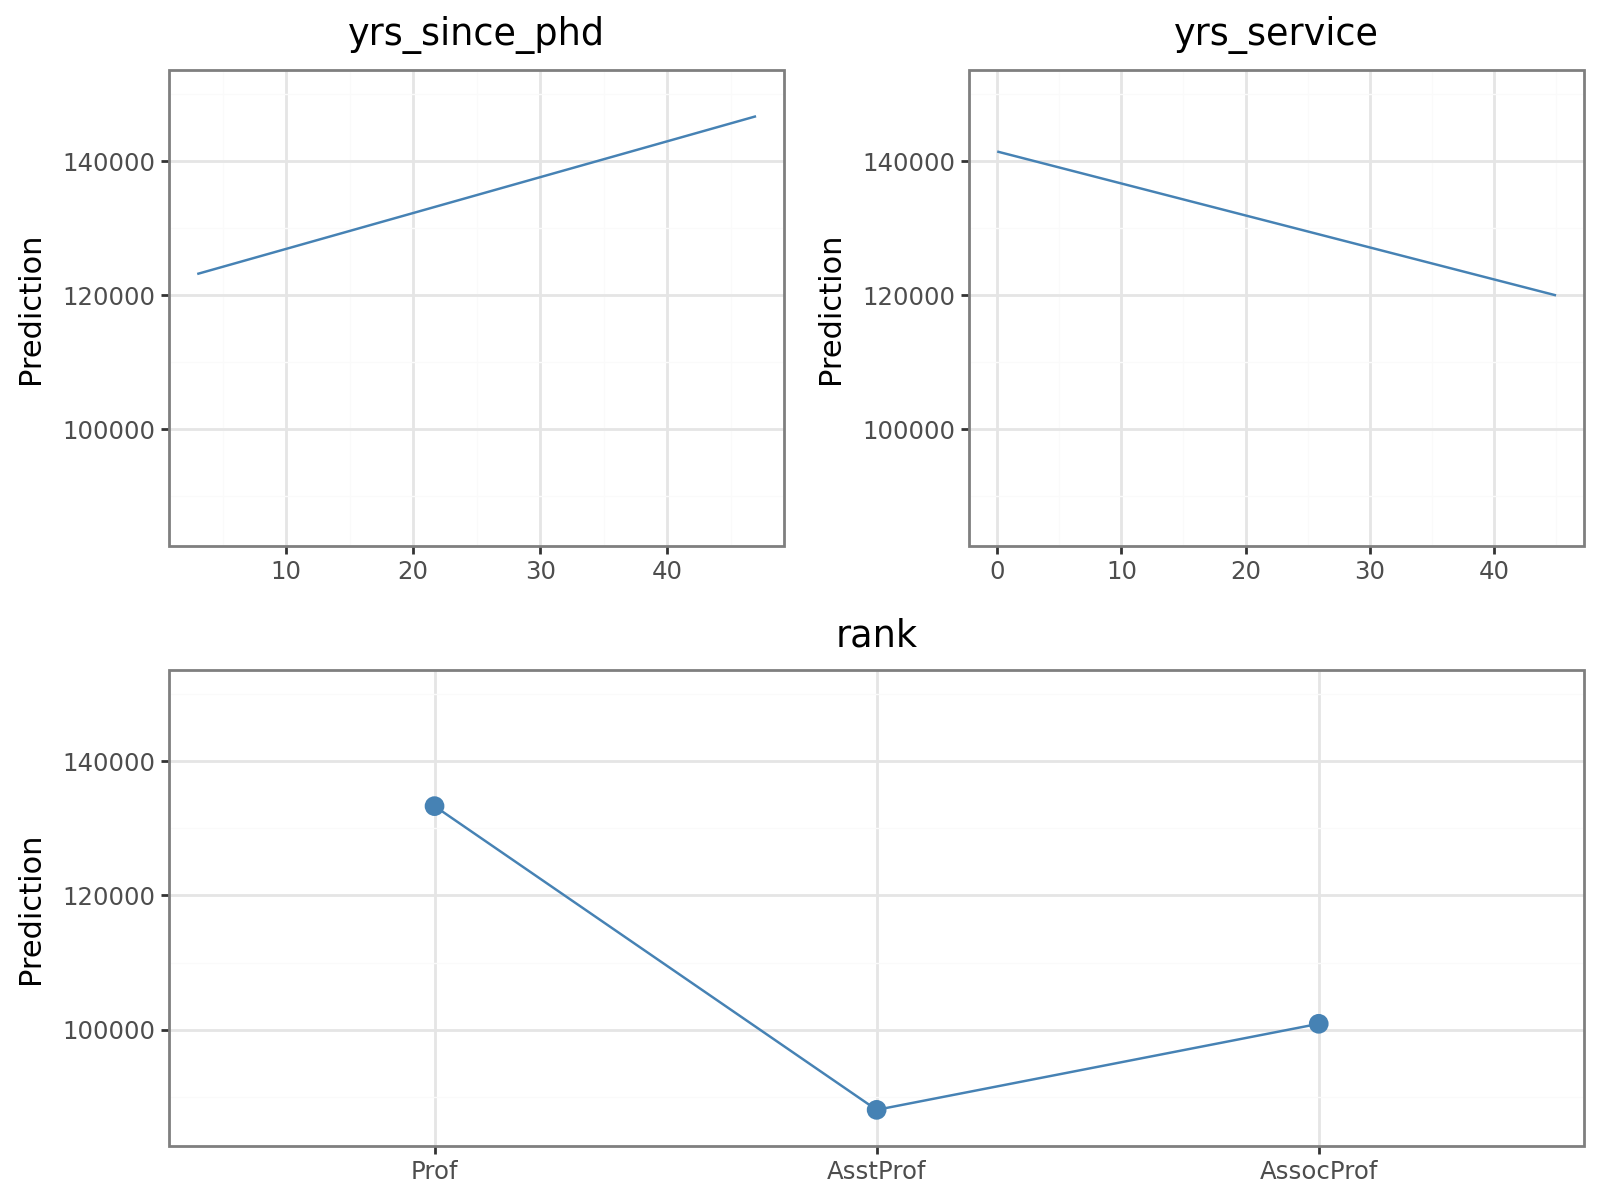

In [38]:
# pred_plot_sm (existing)
start = time.time()
plot_ols_pred = pred_plot_sm(ols_model.fitted, salary, incl=["yrs_since_phd", "yrs_service", "rank"], nnv=30)
ols_pred_time = time.time() - start
print(f"pred_plot_sm: {ols_pred_time:.3f}s")
plot_ols_pred

pdp_sm (fast): 0.046s


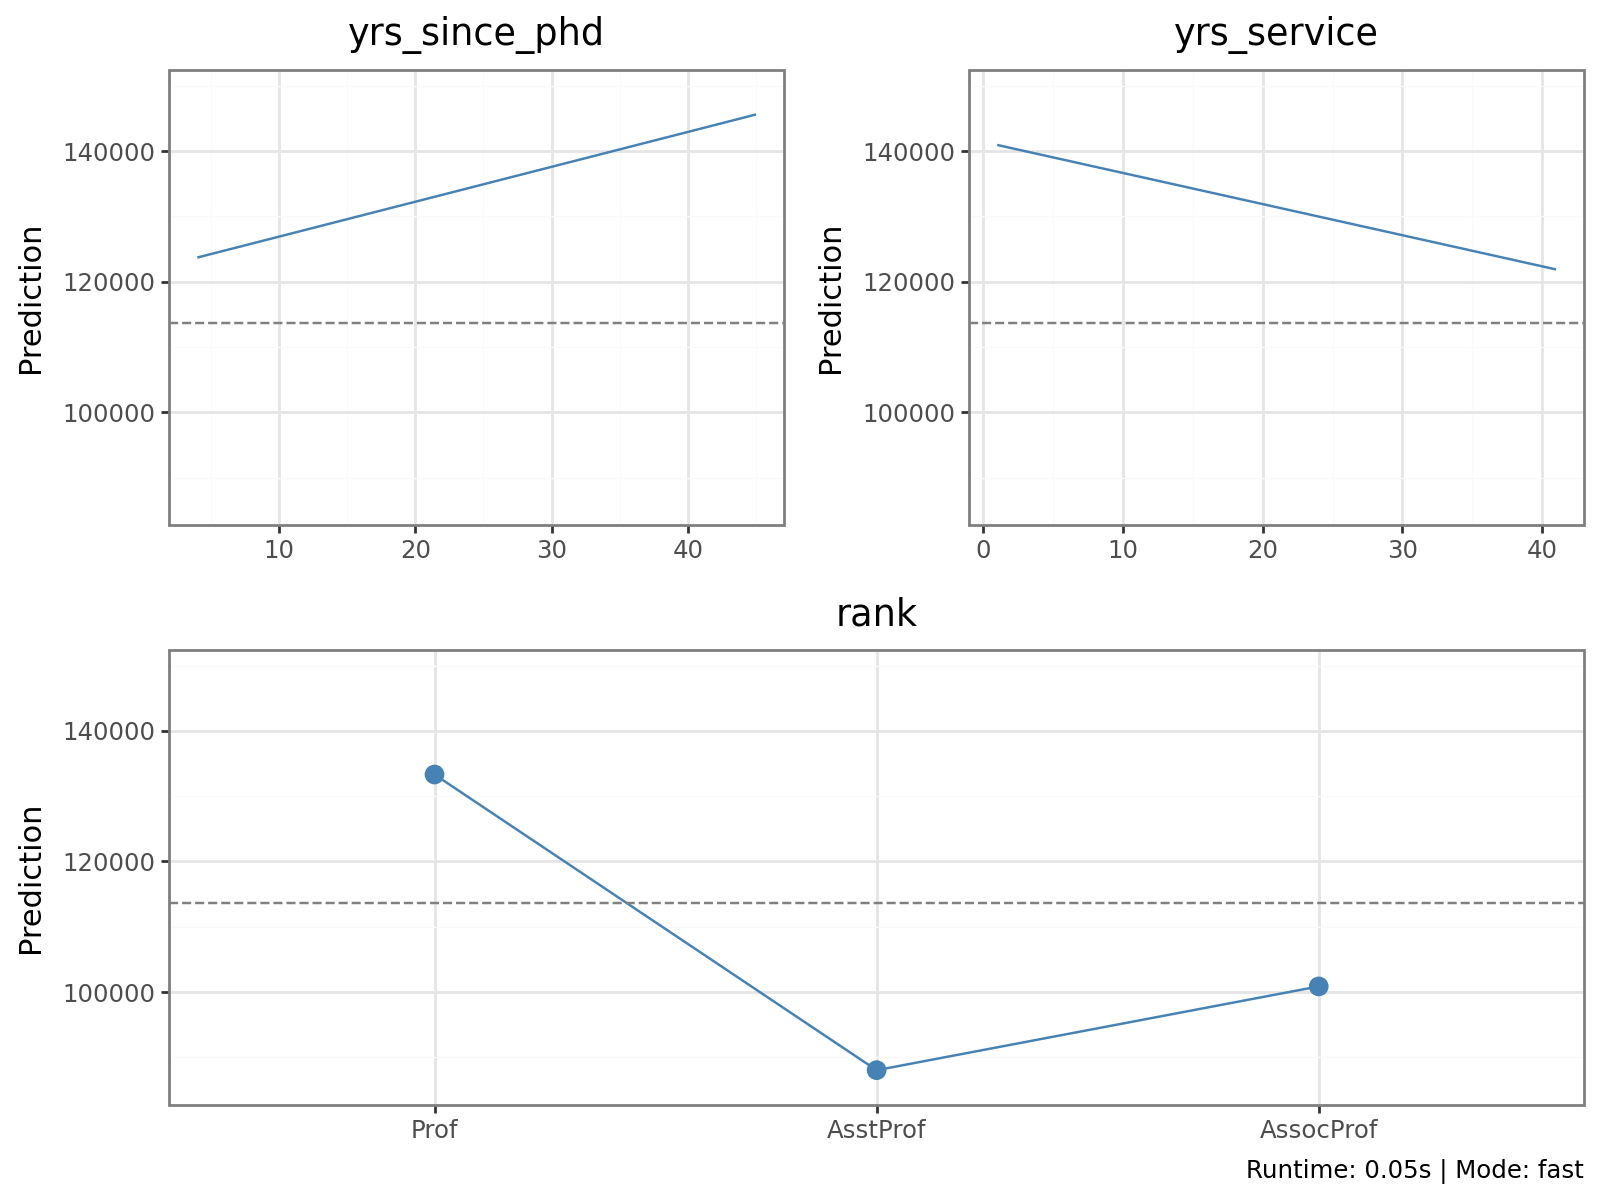

In [39]:
# pdp_sm - Fast
plot_ols_fast, _, ols_fast_time = pdp_sm(
    ols_model.fitted, salary, incl=["yrs_since_phd", "yrs_service", "rank"], mode="fast", grid_resolution=30
)
print(f"pdp_sm (fast): {ols_fast_time:.3f}s")
plot_ols_fast

pdp_sm (pdp): 0.434s


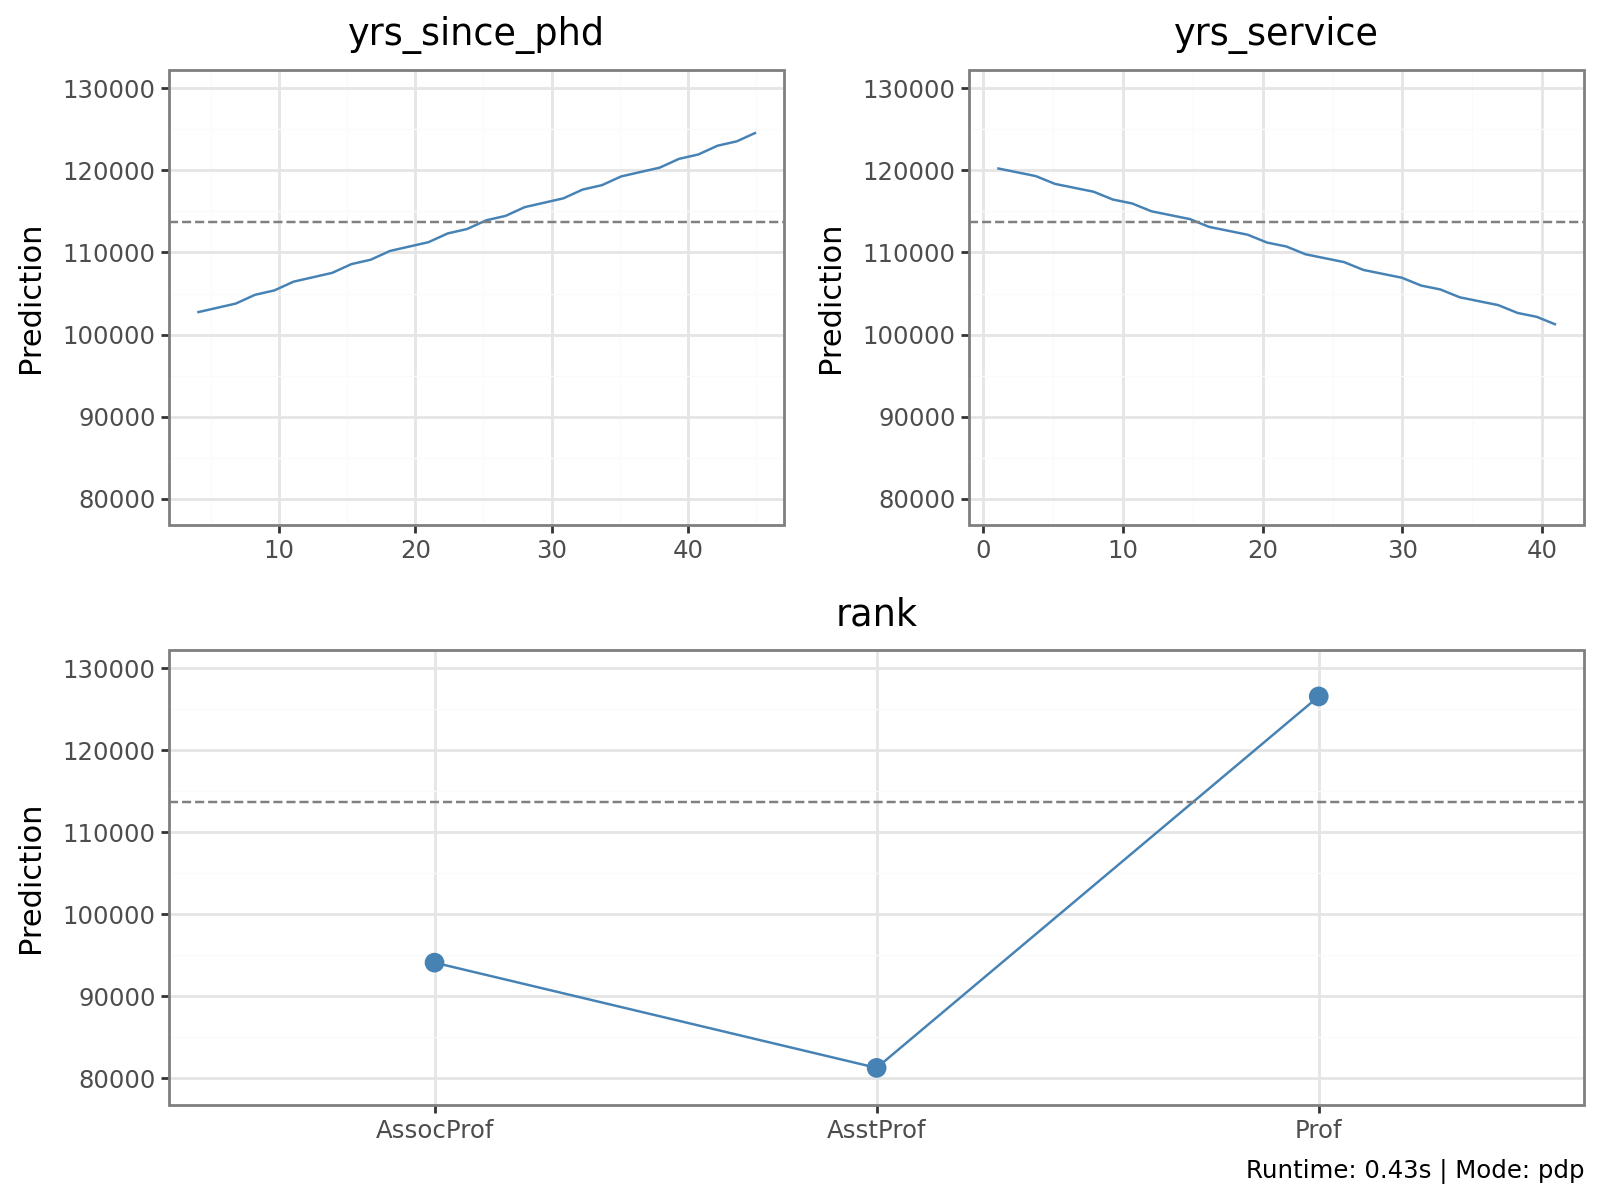

In [40]:
# pdp_sm - PDP
plot_ols_pdp, _, ols_pdp_time = pdp_sm(
    ols_model.fitted, salary, incl=["yrs_since_phd", "yrs_service", "rank"], mode="pdp", n_sample=300, grid_resolution=30
)
print(f"pdp_sm (pdp): {ols_pdp_time:.3f}s")
plot_ols_pdp

OLS Regression Interactions: 1.021s


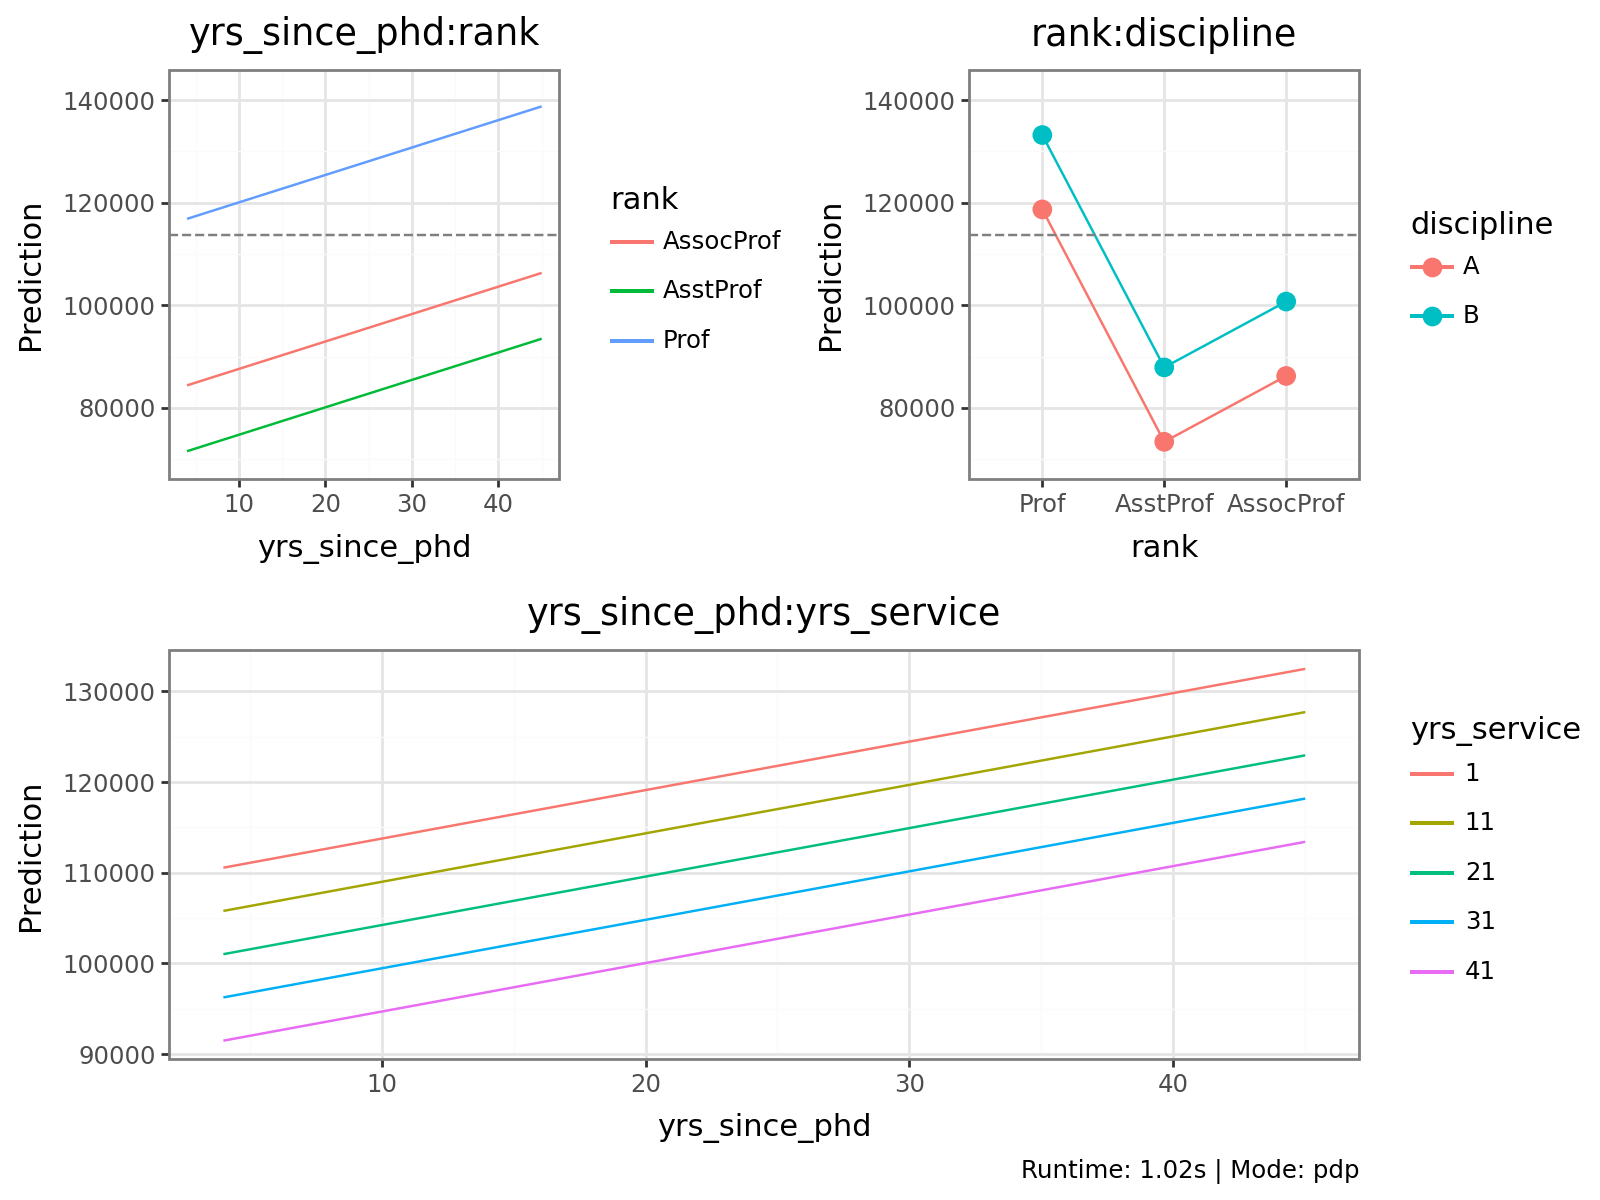

In [41]:
# OLS Regression Interactions - all types
plot_ols_int, _, ols_int_time = pdp_sm(
    ols_model.fitted, salary, incl=[],
    incl_int=["yrs_since_phd:rank", "rank:discipline", "yrs_since_phd:yrs_service"],
    mode="pdp", n_sample=300, grid_resolution=20
)
print(f"OLS Regression Interactions: {ols_int_time:.3f}s")
plot_ols_int

---
# 6. Timing Summary

In [42]:
print("=" * 65)
print("TIMING SUMMARY")
print("=" * 65)

print(f"\n--- SKLEARN MODELS (pdp_sk) ---")

print(f"\nRandom Forest Classification (n={titanic.shape[0]}):")
print(f"  pred_plot_sk:     {rf_clf_pred_time:.3f}s")
print(f"  pdp_sk (fast):    {rf_clf_fast_time:.3f}s")
print(f"  pdp_sk (pdp):     {rf_clf_pdp_time:.3f}s")

print(f"\nXGBoost Classification:")
print(f"  pred_plot_sk:     {xgb_clf_pred_time:.3f}s")
print(f"  pdp_sk (fast):    {xgb_clf_fast_time:.3f}s")
print(f"  pdp_sk (pdp):     {xgb_clf_pdp_time:.3f}s")

print(f"\nMLP Classification:")
print(f"  pred_plot_sk:     {mlp_clf_pred_time:.3f}s")
print(f"  pdp_sk (fast):    {mlp_clf_fast_time:.3f}s")
print(f"  pdp_sk (pdp):     {mlp_clf_pdp_time:.3f}s")

print(f"\n--- STATSMODELS (pdp_sm) ---")

print(f"\nLogistic Regression (n={titanic.shape[0]}):")
print(f"  pred_plot_sm:     {log_pred_time:.3f}s")
print(f"  pdp_sm (fast):    {log_fast_time:.3f}s")
print(f"  pdp_sm (pdp):     {log_pdp_time:.3f}s")

print(f"\nOLS Regression (n={salary.shape[0]}):")
print(f"  pred_plot_sm:     {ols_pred_time:.3f}s")
print(f"  pdp_sm (fast):    {ols_fast_time:.3f}s")
print(f"  pdp_sm (pdp):     {ols_pdp_time:.3f}s")

TIMING SUMMARY

--- SKLEARN MODELS (pdp_sk) ---

Random Forest Classification (n=1043):
  pred_plot_sk:     0.083s
  pdp_sk (fast):    0.095s
  pdp_sk (pdp):     0.380s

XGBoost Classification:
  pred_plot_sk:     0.109s
  pdp_sk (fast):    0.073s
  pdp_sk (pdp):     0.494s

MLP Classification:
  pred_plot_sk:     0.060s
  pdp_sk (fast):    0.041s
  pdp_sk (pdp):     0.139s

--- STATSMODELS (pdp_sm) ---

Logistic Regression (n=1043):
  pred_plot_sm:     0.080s
  pdp_sm (fast):    0.054s
  pdp_sm (pdp):     0.262s

OLS Regression (n=397):
  pred_plot_sm:     0.059s
  pdp_sm (fast):    0.046s
  pdp_sm (pdp):     0.434s


---
# Notes

- **Fast mode** is similar to `pred_plot_*` - sets other variables to mean/mode
- **PDP mode** averages predictions across the data distribution (true partial dependence)
- PDP mode is slower but gives more accurate marginal effects
- Use `n_sample` to control speed vs accuracy tradeoff in PDP mode
- Both functions return `(plot, data_dict, runtime)` for inspection and testing
- `pdp_sk` works with sklearn models (rforest, xgboost, mlp)
- `pdp_sm` works with statsmodels models (logistic, regress)